# IIR example

This example demonstrates how to use the IIR filter

In [1]:
# Set environment variable to use a custom configuration file location
import os
os.environ["PYRPL_USER_DIR"] = "../pyrpl_user_dir/"

In [2]:
from pyrpl import Pyrpl, logger, logging
logging.disable(logging.WARNING) # Make the program less verbose
from pyrpl.software_modules.lockbox.models import FabryPerot, LockboxModuleDictProperty, PiezoOutput

class FabryPerot2Outputs(FabryPerot): 
    """
    A high finesse Fabry Perot using two output signals
    """
    outputs = LockboxModuleDictProperty(piezo=PiezoOutput,
                                        aux_output=PiezoOutput)# In case iir_example.yml already defined the Lockbox type
            
        
p = Pyrpl("iir_example")

C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
from pyrpl import Pyrpl
p_shg = Pyrpl('shg_test') # We use a second redpitaya to measure an out-of-loop error signal
p_shg.lockbox0.lock()

True

## Setup a lockbox with 2 outputs (with/without iir)
- We will use the "piezo" output as a standard pid output to acquire the lock
- The "aux_output" will include the IIR filter and will only be activated at the last stage of the lock sequence

In [4]:
from pyrpl.software_modules.lockbox.models.fabryperot import FabryPerot, LockboxModuleDictProperty, PiezoOutput

    
p.lockbox.classname = "FabryPerot2Outputs"
# classes heriting from Lockbox can be chosen as "classname"

lockbox = p.lockbox
lockbox.unlock()

## parameters of the physical model
lockbox.eta = 0.84 # mode matching
lockbox.wavelength = 532e-9
lockbox.finesse = 9
lockbox.round_trip_length = 0.27

## Configure inputs
# transmission 
trans = lockbox.inputs.transmission # actually transmission from infrared beam
trans.input = 'in1'

# pdh
pdh = lockbox.inputs.pdh
# The IQ module is configured by the lockbox (see example2_pdh_generation for details)
pdh.mod_amp = 1.
pdh.mod_freq = 21e6
pdh.quadrature_factor = 10
pdh.bandwidth = [6.5e5, 6.5e5] # second-order lowpass filter
pdh.mod_phase = 180
pdh.mod_output = 'out1'
pdh.input_signal = 'in2' # reflection

## configure outputs
# piezo
piezo = lockbox.outputs.piezo
piezo.sweep_amplitude = 1.
piezo.sweep_frequency = 10.
piezo.sweep_waveform = "ramp"
piezo.output_channel = 'out2'
piezo.tf_type = 'flat'

piezo.assisted_design = False
piezo.dc_gain = 250e-9 # in m/V
piezo.p = 15 # open-loop proportional gain (oscillates at 20)
piezo.i = 1500 # open-loop integral unity-gain frequency (corner frequency at 100 Hz)

# aux_output
aux_output = lockbox.outputs.aux_output
aux_output.output_channel = 'out2'

aux_output.assisted_design = False
aux_output.dc_gain = 250e-9 # in m/V
aux_output.p = 300 #1250 #25  # open-loop integral unity-gain frequency (tiny oscillations around 600)
aux_output.i = 3e4 #6.25e5 # open-loop proportional gain (keep corner frequency at 100 Hz)
aux_output.extra_module = 'iir'
aux_output.tf_type = 'flat'

## configure the LockSequence
sequence = p.lockbox.sequence

# remove all stages in the sequence (except for the first)
while len(p.lockbox.sequence)>1:
    p.lockbox.sequence.remove(p.lockbox.sequence[-1])

# configure first stage
stage0 = p.lockbox.sequence[0]
stage0.outputs.piezo.lock_on = False # Can be either True, False, or "ignore"
stage0.outputs.piezo.reset_offset = True # reset integrator offset at 1 V
stage0.outputs.piezo.offset = -1.
stage0.outputs.aux_output.lock_on = False # Can be either True, False, or "ignore"
stage0.outputs.aux_output.reset_offset = True # reset integrator offset at 0 V
stage0.outputs.aux_output.offset = 0

# Create and configure second stage
sequence.append({})
stage1 = p.lockbox.sequence[1]
stage1.input = 'transmission'
stage1.setpoint = -0.5 # in units of cavity linewidth
stage1.duration = 0.5 # time before switching to next stage
stage1.gain_factor = -0.01 # Gain to apply compared to output transfer function
stage1.outputs.piezo.reset_offset = True
stage1.outputs.piezo.offset = -0.7
stage1.outputs.piezo.lock_on = True
stage1.outputs.aux_output.reset_offset = True
stage1.outputs.aux_output.offset = 0
stage1.outputs.aux_output.lock_on = False

# Create and configure third stage
sequence.append({})
stage2 = p.lockbox.sequence[2]
stage2.input = 'pdh'
stage2.setpoint = 0 # in units of cavity linewidth
stage2.gain_factor = 1. # Gain to apply compared to output transfer function
stage2.duration = 0.5
stage2.outputs.piezo.reset_offset = False
stage2.outputs.piezo.lock_on = True

sequence.append({})
stage3 = p.lockbox.sequence[3]
stage3.input = 'pdh'
stage3.setpoint = 0 # in units of cavity linewidth
stage3.gain_factor = 1. # Gain to apply compared to output transfer function
stage3.outputs.piezo.reset_offset = False
stage3.outputs.piezo.lock_on = False
stage3.outputs.aux_output.reset_offset = False
stage3.outputs.aux_output.lock_on = True

In [5]:
## Calibrate inputs

p.lockbox.calibrate_all()

[]

## Define useful functions for loop measurements

In [8]:
from pylab import *

def current_output():
    """find which output is locked"""
    if p.lockbox.current_stage=='unlock':
        raise(ValueError("Lockbox unlocked"))
    for output in p.lockbox.current_stage.outputs:
        if(output.lock_on):
            return getattr(p.lockbox.outputs, output.name)

def bode_plot(freqs, zs, axes=None, label=None, color=None, linestyle=None):
    """
    Plots the magnitude and phase of a complex series.
    """
    if axes is None:
        fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].semilogx(freqs, 20*np.log10(np.abs(zs)), linestyle=linestyle, color=color, label=label)
    axes[1].semilogx(freqs, 180/np.pi*np.angle(zs), ms=1, linestyle=linestyle, color=color, label=label)
    #axes[0].set_xticklabels([])
    plt.setp(axes[0].get_xticklabels(), visible=False)
    axes[1].set_ylim(-200, 200)
    axes[1].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel("Amplitude (dB)")
    axes[1].set_ylabel(r"Phase ($^\circ$)")

    #axes[0].set_yticks([-120, -60, 0, 60, 120])
    axes[1].set_yticks([-180, -90, 0, 90, ])
    axes[0].tick_params(axis='x', which='minor', bottom=True)
    axes[1].tick_params(axis='x', which='minor', bottom=True)
    axes[0].grid(True)
    axes[1].grid(True)
    plt.subplots_adjust(hspace=0.2, top=0.93)
    return axes


def measure_closed_loop(start_freq=10, stop_freq=1e6, points=300, rbw=75, average_per_point=1, q_factor_min=20,
                        is_plot=True, amplitude_start=0.2, is_auto_amplitude=True):
    p.networkanalyzer.output_direct = "out2"
    p.networkanalyzer.input = "out2"
    p.networkanalyzer.acbandwidth = 4
    p.networkanalyzer.logscale = True
    p.networkanalyzer.trace_average = 1
    p.networkanalyzer.average_per_point = average_per_point
    p.networkanalyzer.points = points

    p.networkanalyzer.start_freq = start_freq # 2e4
    p.networkanalyzer.stop_freq = stop_freq # 5e5

    p.networkanalyzer.auto_bandwidth = True
    p.networkanalyzer.q_factor_min = q_factor_min
    p.networkanalyzer.rbw = rbw

    p.networkanalyzer.amplitude = amplitude_start #0.2 
    p.networkanalyzer.auto_amplitude = is_auto_amplitude
    p.networkanalyzer.target_dbv = -40
    p.networkanalyzer.auto_amp_min = 0.001
    p.networkanalyzer.auto_amp_max = 0.2
    
    freqs = p.networkanalyzer.frequencies
    closed_loop_tf = p.networkanalyzer.single()
    try:
        current_output()
    except ValueError: 
        controller_tf = None
    else:
        controller_tf = current_output().transfer_function_controller(freqs, p.lockbox.current_stage)
    return freqs, closed_loop_tf, controller_tf



def measure_loop_tf_and_background(start_freq_tf=30, stop_freq_tf=5e5,
            points_tf=500, q_factor_min=5, rbw=5, avg_per_point=1, start_amp=None):
    """
    For accurate results at high frequency, where the open-loop gain is small, it is advisable to normalize 
    the closed-loop transfer function with the background transfer function (transfer function measured 
    without pdh modulation). This efficiently captures the various analog crosstalks and digital delay in 
    the output summators.
    """
    from pyrpl.async_utils import sleep
    out = current_output()
    slope_bw_per_v = p.lockbox.inputs.pdh.expected_slope(0)  
    
    # MEASURE TRANSFER FUNCTION
    if start_amp is None:
        start_amp = min(10**(-55/10)*np.abs(out.transfer_function([start_freq_tf]))[0], 0.2)
    
    freqs_tf, closed_loop_tf, controller_tf = \
    measure_closed_loop(start_freq=start_freq_tf, stop_freq=stop_freq_tf, rbw=rbw, points=points_tf, 
                        amplitude_start=start_amp, 
                        q_factor_min=q_factor_min, average_per_point=avg_per_point)
    
    final_amplitude = p.networkanalyzer.amplitude_list[-1]
    
    # MEASURE BACKGROUND TRANSFER FUNCTION (cross-talk without pdh modulation)
    old_amp = p.lockbox.inputs.pdh.mod_amp
    old_filter = out.additional_filter
    out.additional_filter = old_filter[:3] + [-1] # add a high-pass filter to avoid saturation during background measurement
    p.lockbox.inputs.pdh.mod_amp = 0
    sleep(5) # wati 5 s for filter to set up
    # reset offset to 0 to make sure no saturation occurs during background measurement 
    out.pid.ival = 0
    p.lockbox.outputs.piezo.pid.ival = 0
    
    
    freqs_tf_bg, tf_bg, _ = \
    measure_closed_loop(start_freq=start_freq_tf, stop_freq=stop_freq_tf, rbw=rbw, points=100, q_factor_min=q_factor_min,
                        amplitude_start=final_amplitude, average_per_point=avg_per_point, is_auto_amplitude=False)

    p.lockbox.inputs.pdh.mod_amp = old_amp
    out.additional_filter = old_filter

    
    return dict(freqs_tf=freqs_tf, closed_loop_tf=closed_loop_tf, controller_tf=controller_tf, 
                slope_bw_per_v=slope_bw_per_v, background_correction=(freqs_tf_bg, tf_bg))



def get_open_loop_and_plant(freqs_tf, closed_loop_tf, controller_tf, background_correction='delay', **kwds):
    if background_correction=="delay":
        closed_loop_tf_corr = closed_loop_tf*np.exp(-1j*2*np.pi*freqs_tf*8e-9*5)
    elif background_correction is not None:
        freqs_corr, corr = background_correction
        freqs_corr = np.real(freqs_corr)
        corr = np.interp(freqs_tf, freqs_corr, corr)
        closed_loop_tf_corr = closed_loop_tf/corr # Compensate delay of output summator
    else:
        closed_loop_tf_corr = closed_loop_loaded
         
    open_loop_tf = 1 - 1./closed_loop_tf_corr
    plant_tf = open_loop_tf/controller_tf
    
    return open_loop_tf, plant_tf



def plot_loop_tfs(freqs_tf, closed_loop_tf, controller_tf, background_correction='delay', 
                  gain_margin=None, phase_margin=None, axes=None, 
                  is_plot_plant=True,
                  is_plot_controller=True,
                  is_plot_closed_loop=True,
                  **kwds):
    """
    Calculate and plots the following transfer-function:
      - closed loop corrected (correct for output sumator tf)
      - open loop (1 - 1/closed_loop_corrected)
      - controller (user provided)
      - plant (deduced from plant = open_loop/controller)
      
    background_correction can be 'delay' (take into account the 5 cycles of delay at the sumator), or
    a npy filename containing measured sumator transfer function (freqs_corr, corr)
    """
    open_loop_tf, plant_tf = get_open_loop_and_plant(freqs_tf, closed_loop_tf, controller_tf, background_correction=background_correction)
    
    axes = bode_plot(freqs_tf, open_loop_tf, label='open-loop', axes=axes)
        
    if is_plot_controller:
        bode_plot(freqs_tf, controller_tf*1e-2, axes=axes, label='controller', linestyle='--')
    if is_plot_closed_loop:
        bode_plot(freqs_tf, closed_loop_tf, axes=axes, label='closed-loop')
    if is_plot_plant:
        bode_plot(freqs_tf, plant_tf, axes=axes, label='plant')
    # Add plot legend
    axes[0].legend(ncol=2, bbox_to_anchor=(0.73, -0.26), loc='lower right')
    axes[0].set_zorder(100)
    
    if gain_margin is not None:
        gain_margin_val, gain_margin_freq = gain_margin
        axes[0].plot([min(freqs_tf), gain_margin_freq], [0]*2, 'k')
        axes[0].plot([gain_margin_freq, gain_margin_freq], [0, 20*np.log10(gain_margin_val)], 'k')
        axes[0].plot([gain_margin_freq], [20*np.log10(gain_margin_val)], 'og')
    if phase_margin is not None:
        phase_margin_val, phase_margin_freq = phase_margin
        axes[1].plot([min(freqs_tf), phase_margin_freq], [0]*2, 'k')
        axes[1].plot([phase_margin_freq, phase_margin_freq], [0, 180/np.pi*phase_margin_val], 'k')
        axes[1].plot([phase_margin_freq], [180/np.pi*phase_margin_val], 'or')
    return open_loop_tf, plant_tf

def get_gain_phase_margin(freqs, open_loop_tf):
    gain_margin_amp = 1e-100
    gain_margin_phase = 0
    gain_margin_freq = 0

    phase_margin = 2*np.pi
    phase_margin_amp = 0
    phase_margin_freq = 0
    for index in range(len(freqs)-1):
        z = open_loop_tf[index]
        znext = open_loop_tf[index + 1]
        if phase_margin_freq==0:
            if (np.abs(znext)<1) and (np.abs(z)>1): # crossing unit circle
                if (np.angle(z) > 0): # and (np.angle(z) < min_crossing_phase):
                    weight1, weight2 = (np.abs(z) - 1)/(np.abs(z) - np.abs(znext)), -(np.abs(znext) - 1)/(np.abs(z) - np.abs(znext))
                    point = weight2*z + weight1*znext
                    phase_margin = np.angle(point)
                    phase_margin_amp = 1 # by definition
                    phase_margin_freq = weight2*freqs[index] + weight1*freqs[index + 1]
        if (np.angle(znext)<0) and (np.angle(z)>0): # crossing real axis
            weight1, weight2 = np.imag(z)/(np.imag(z) - np.imag(znext)), -np.imag(znext)/(np.imag(z) - np.imag(znext))
            crossing_value = np.real(weight2*z + weight1*znext)
            if crossing_value>gain_margin_amp and crossing_value<1:
                gain_margin_amp = crossing_value
                gain_margin_phase = 0 # by definition
                gain_margin_freq = weight2*freqs[index] +  weight1*freqs[index + 1]


    z_crossing_real = gain_margin_amp*np.exp(1j*gain_margin_phase)
    z_crossing_circle = phase_margin_amp*np.exp(1j*phase_margin)
    return (np.abs(z_crossing_real), gain_margin_freq), (np.angle(z_crossing_circle), phase_margin_freq)

def plot_nyquist_diagram(freqs, open_loop_tf, min_freq=1e4, max_freq=1e6, ax=None):
    mask = (freqs<max_freq)*(freqs>min_freq)
    if ax is None:
        ax = plt.figure()
    ax.plot(np.real(open_loop_tf[mask]), np.imag(open_loop_tf[mask]), '-')
    
    (inverse_gain_margin, gain_margin_freq), (phase_margin, phase_margin_freq) = \
                                get_phase_gain_margin(freqs[mask], open_loop_tf[mask])
    #plt.annotate(f"f = {max_crossing_freq:.0f} Hz", (np.real(z_crossing_real), np.imag(z_crossing_real)))
    ax.plot([inverse_gain_margin], [0], 'og', 
             label=f"gain margin: x {1./inverse_gain_margin:.2f} @ {gain_margin_freq:.0f} Hz")
            # {20*np.log10(1./gain_margin_amp):.2f} dB (=
    ax.plot([np.real(np.exp(1j*phase_margin))], [np.imag(np.exp(1j*phase_margin))], 'or', 
             label=f"phase margin: {phase_margin*180/np.pi:.1f}$^\circ$ @ {phase_margin_freq:.0f} Hz")
    ax.legend()
    thetas = np.linspace(0, 2*np.pi, 1000)
    ax.plot(np.sin(thetas), np.cos(thetas), ':k')
    ax.plot([0, 2], [0, 0], ':k')
    NYQUIST_PLOT_LIM = 1.5
    ax.set_xlabel("Re(open loop tf)")
    ax.set_ylabel("Im(open loop tf)")

    ax.set_xlim(-NYQUIST_PLOT_LIM, NYQUIST_PLOT_LIM)
    ax.set_ylim(-NYQUIST_PLOT_LIM, NYQUIST_PLOT_LIM)
    ax.set_aspect("equal")
    return ax

def lock_at_stage(index):
    for stage_index in range(index + 1):
        p.lockbox.sequence[stage_index].execute()
    return p.lockbox.is_locked()

def analyze_loop_tf(freqs_tf, closed_loop_tf, controller_tf, background_correction, nyquist_min_freq=100, 
                    is_plot_plant=True, is_plot_controller=True, is_plot_closed_loop=True, axes=None, **kwds):
    fig = plt.figure(constrained_layout=True, figsize=(14, 4))
    gs = fig.add_gridspec(2, 10)
    if axes is None:
        ax_mag = fig.add_subplot(gs[0, :7])
        ax_phase = fig.add_subplot(gs[1, :7], sharex=ax_mag)
        ax_nyquist = fig.add_subplot(gs[:, 7:])
    else:
        ax_mag, ax_phase, ax_nyquist = axes

    bg_tuple = background_correction #(data.freqs_tf_bg, data.tf_bg)

    open_loop_tf, plant_tf = get_open_loop_and_plant(freqs_tf, closed_loop_tf, controller_tf, background_correction=bg_tuple)
    (inverse_gain_margin, gain_margin_freq), (phase_margin, phase_margin_freq) = get_gain_phase_margin(freqs_tf, open_loop_tf)
    plot_nyquist_diagram(freqs_tf, 
                        open_loop_tf, 
                        ax=ax_nyquist,
                        min_freq=nyquist_min_freq)
    open_loop_tf, plant_tf = plot_loop_tfs(freqs_tf, 
                                           closed_loop_tf=closed_loop_tf, 
                                           controller_tf=controller_tf, 
                                           phase_margin=(phase_margin, phase_margin_freq),
                                           gain_margin=(inverse_gain_margin, gain_margin_freq),
                                           axes=[ax_mag, ax_phase], 
                                           background_correction=bg_tuple,
                                           is_plot_plant=is_plot_plant,
                                           is_plot_controller=is_plot_controller,
                                           is_plot_closed_loop=is_plot_closed_loop)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    
    return fig


## Reload loop transfer function from example5

C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12640\3723930064.py:72: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if background_correction=="delay":


array([<AxesSubplot:ylabel='Amplitude (dB)'>,
       <AxesSubplot:xlabel='Frequency (Hz)', ylabel='Phase ($^\\circ$)'>],
      dtype=object)

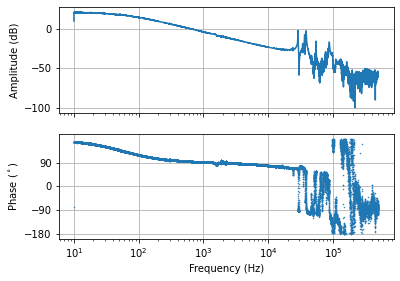

In [14]:
import h5py
kwds = {}
with h5py.File("../example5_loop_transfer_function/data/data.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]

open_loop_tf, plant_tf = get_open_loop_and_plant(**kwds)
bode_plot(kwds['freqs_tf'], plant_tf)

## Save plant's transfer function into pyrpl's database

In [15]:
from pyrpl import CurveDB

c = CurveDB("piezo_tf")
c.data = kwds["freqs_tf"], plant_tf
c.save()
p.rp.iir.data_curve = c.pk # The curve will be displayed in the iir interface

## Configure iir filter

To help design the desired transfer function, a response curve can be selected in the IIR widget:
Once the iir has been configured (after executing the next cell), the iir widget should look like the following 
 - in green: the response curve to be cancelled-out
 - in yellow: the iir filter response based on the current design
 - in red: the product of those 2 transfer functions

One can then iteratively add zeros and poles untill the product of the transfer-functions has an approximately flat magnitude. If the plant is close to a minimum-phase system, the phase response should be flat as well.
 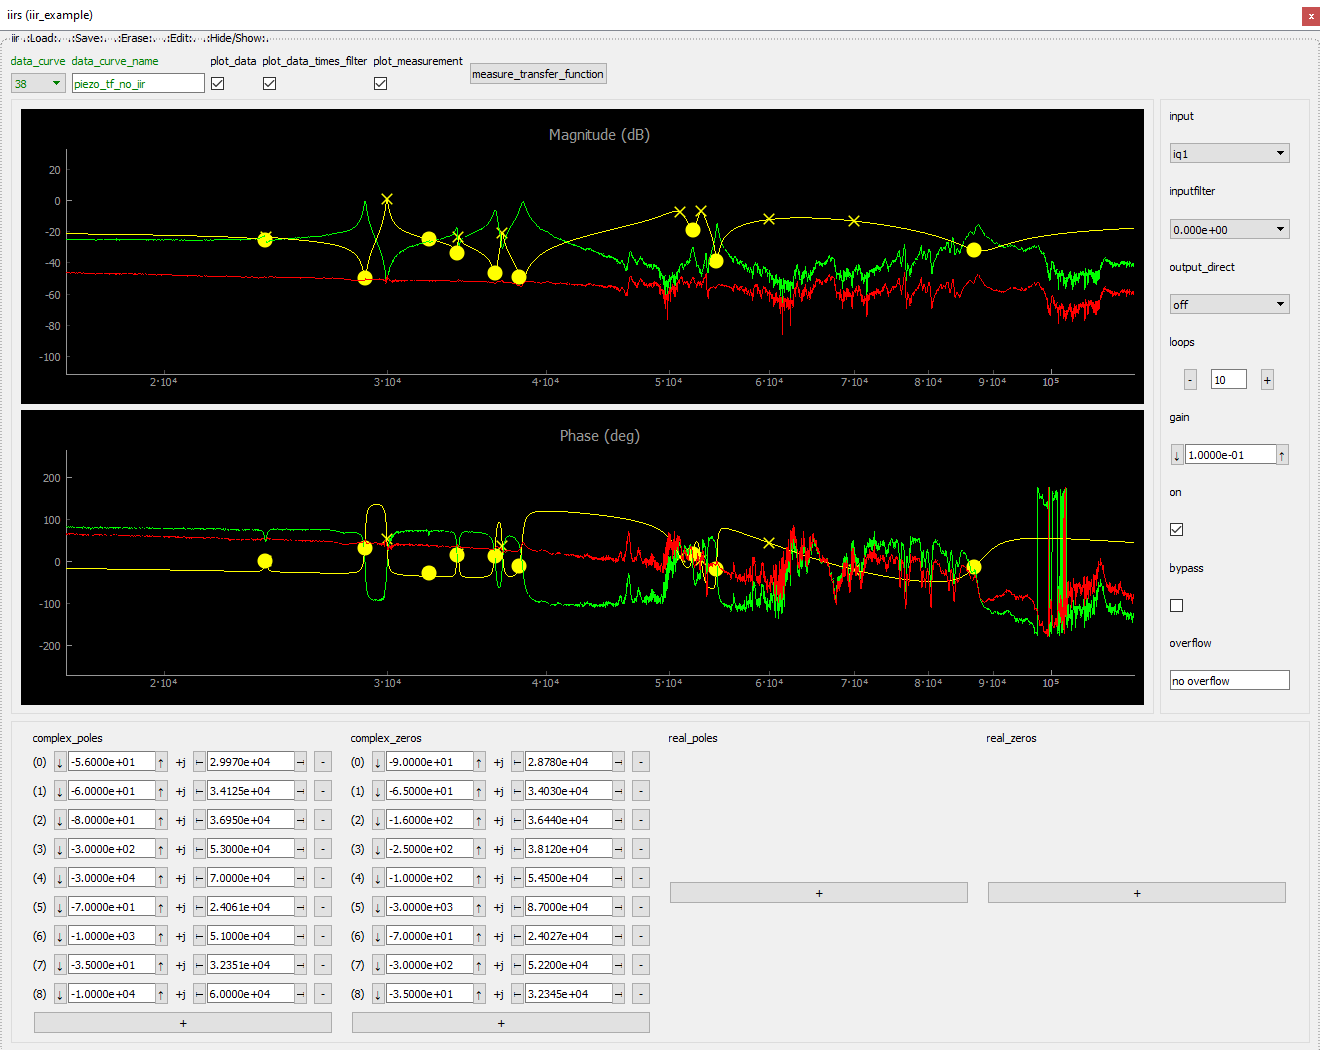

In [16]:
# Coefficients can be defined via the GUI or via the python interface (first pole used to be -40 + 29910j)
iir = p.rp.iir
iir.zeros = [(-90+28780j), (-65+34030j), (-160+36440j), (-250+38120j), (-100+54500j), (-3000+87000j), (-70+24027j), (-300+52200j), (-35+32345j)]  # complex conjugated zeros are automatically added
iir.poles = [(-56+29970j), (-60+34125j), (-80+36950j), (-300+53000j), (-30000+70000j), (-70+24061j), (-1000+51000j), (-35+32351j), (-10000+60000j)] # same for poles
iir.loops = 10
iir.gain = 0.1 # Avoid saturation (individual biquads and total transfer-function should be  < 0 dB)

Once the desired filter has been configured, don't forget to **measure** it's transfer function (orange dots) to make sure it matches the designed one (yellow curve): to automatically measure the filter's transfer function using the network analyzer, press the "measure_transfer_function" button or execute the following cell:

In [18]:
freqs_iir, tf_iir = p.rp.iir.measure_transfer_function()

with h5py.File('./data/iir_tf.h5', 'w') as f:
    f.create_dataset('freqs_iir', data=freqs_iir)
    f.create_dataset('tf_iir', data=tf_iir)

## Measure loop with iir

In [37]:
START_FREQ = 10
STOP_FREQ = 5e5
Q_FACTOR_MIN = 5
RBW = 5
POINTS = 30000
AVG_PER_POINT = 1
AMPLITUDE_START = 0.3

kwds = measure_loop_tf_and_background(start_freq_tf=START_FREQ, 
                                      stop_freq_tf=STOP_FREQ, 
                                      q_factor_min=Q_FACTOR_MIN, 
                                      rbw=RBW, 
                                      points_tf=POINTS,
                                      avg_per_point=AVG_PER_POINT,
                                      start_amp=AMPLITUDE_START)


In [39]:
import h5py

with h5py.File("./data/data.h5", 'w') as f:
    for key, value in kwds.items():
        dset = f.create_dataset(key, data=value)

C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12640\1900407486.py:33: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)


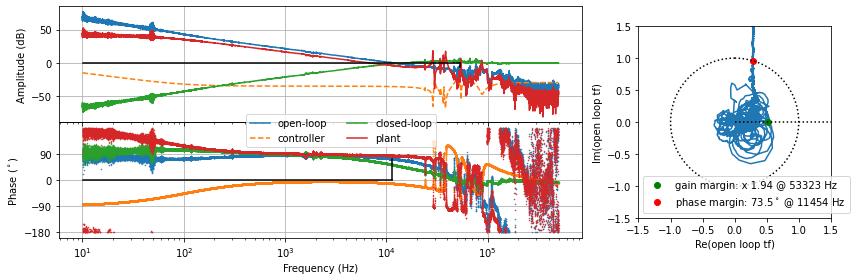

In [38]:
fig = analyze_loop_tf(**kwds, nyquist_min_freq=200)

C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_17380\3008719939.py:33: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_17380\3008719939.py:259: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


saving fig G:/Mon Drive/exsqueez/measurements/squeezer\loop_tf_and_noise\2022-09-23_11-56-00_loop_tf_and_noise_FIG1.pdf


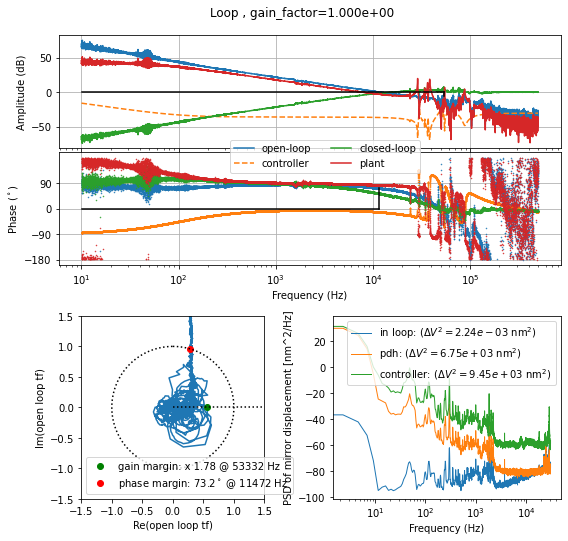

In [22]:
%%analysis_cell

data = load_acquisition()

analyze_loop_tf_and_noise(data)

data.save_fig(gcf())

## compare locks

In [110]:
DS_FACTOR = 5

p.spectrumanalyzer.setup(baseband=True, span=1e5, input1_baseband=p.lockbox.inputs.pdh, input2_baseband=p.lockbox.inputs.reflection)


freqs_psd = p.spectrumanalyzer.frequencies[::DS_FACTOR]

lock_at_stage(2)
psd_pdh_no_iir, psd_refl_no_iir, real_cross_no_iir, imag_cross_no_iir = p.spectrumanalyzer.single()[:, ::DS_FACTOR]

p.lockbox.lock()
psd_pdh, psd_refl, real_cross, imag_cross = p.spectrumanalyzer.single()[:, ::DS_FACTOR]


C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\pyqtgraph\graphicsItems\PlotCurveItem.py:153: RuntimeWarning: All-NaN slice encountered
  b = (np.nanmin(d), np.nanmax(d))


In [112]:
import h5py
kwds = dict(freqs_psd=freqs_psd, psd_pdh=psd_pdh, psd_pdh_no_iir=psd_pdh_no_iir)

with h5py.File("./data/psd.h5", 'w') as f:
    for key, value in kwds.items():
        dset = f.create_dataset(key, data=value)

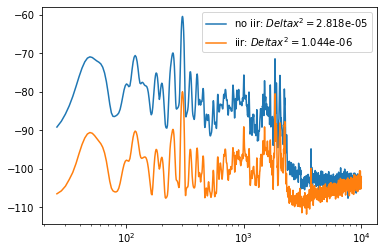

In [118]:
kwds = dict()
with h5py.File("./data/psd.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]
freqs_psd = kwds["freqs_psd"]
psd_pdh_no_iir = kwds["psd_pdh_no_iir"]
psd_pdh = kwds["psd_pdh"]

        
plt.figure()

mask = (freqs_psd>25)*(freqs_psd<1e4)

df = freqs_psd[1] - freqs_psd[0]
var = np.sum(psd_pdh[mask])*df
var_no_iir = np.sum(psd_pdh_no_iir[mask])*df
plt.semilogx(freqs_psd[mask], 10*np.log10(np.abs(psd_pdh_no_iir[mask])), label=f"no iir: $Delta x^2=${(var_no_iir):.3e}")
plt.semilogx(freqs_psd[mask], 10*np.log10(np.abs(psd_pdh[mask])), label=f"iir: $Delta x^2=${(var):.3e}")

plt.legend()

## compare locks out-of-loop

In [102]:
DS_FACTOR = 5

p_shg.spectrumanalyzer.setup(baseband=True, span=1e5, 
                             input1_baseband=p_shg.lockbox1.inputs.pdh, 
                             input2_baseband=p_shg.lockbox1.inputs.transmission)


freqs_psd = p_shg.spectrumanalyzer.frequencies[::DS_FACTOR]

lock_at_stage(2)
psd_pdh_no_iir, psd_refl_no_iir, real_cross_no_iir, imag_cross_no_iir = p_shg.spectrumanalyzer.single()[:, ::DS_FACTOR]

p.lockbox.lock()
psd_pdh, psd_refl, real_cross, imag_cross = p_shg.spectrumanalyzer.single()[:, ::DS_FACTOR]


C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\pyqtgraph\graphicsItems\PlotCurveItem.py:153: RuntimeWarning: All-NaN slice encountered
  b = (np.nanmin(d), np.nanmax(d))


In [109]:
import h5py
kwds = dict(freqs_psd=freqs_psd, psd_pdh=psd_pdh, psd_pdh_no_iir=psd_pdh_no_iir)

with h5py.File("./data/psd_out_of_loop.h5", 'w') as f:
    for key, value in kwds.items():
        dset = f.create_dataset(key, data=value)

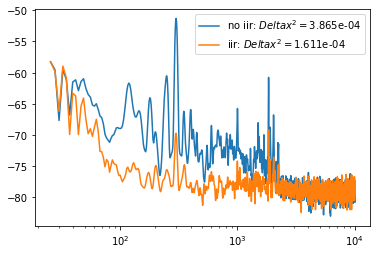

In [117]:
kwds = dict()
with h5py.File("./data/psd_out_of_loop.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]
freqs_psd = kwds["freqs_psd"]
psd_pdh_no_iir = kwds["psd_pdh_no_iir"]
psd_pdh = kwds["psd_pdh"]

        
plt.figure()

mask = (freqs_psd>25)*(freqs_psd<1e4)

df = freqs_psd[1] - freqs_psd[0]
var = np.sum(psd_pdh[mask])*df
var_no_iir = np.sum(psd_pdh_no_iir[mask])*df
plt.semilogx(freqs_psd[mask], 10*np.log10(np.abs(psd_pdh_no_iir[mask])), label=f"no iir: $Delta x^2=${(var_no_iir):.3e}")
plt.semilogx(freqs_psd[mask], 10*np.log10(np.abs(psd_pdh[mask])), label=f"iir: $Delta x^2=${(var):.3e}")

plt.legend()


## Plot the actual figure

C:\Users\jacqu\AppData\Local\Temp\ipykernel_16064\239888662.py:119: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if background_correction=="delay":
C:\Users\jacqu\AppData\Local\Temp\ipykernel_16064\239888662.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\jacqu\AppData\Local\Temp\ipykernel_16064\239888662.py:119: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if background_correction=="delay":
C:\Users\jacqu\AppData\Local\Temp\ipykernel_16064\1922259985.py:38: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000015E80477D60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax_mag.legend(["open-loop no iir", "_nolegend_"

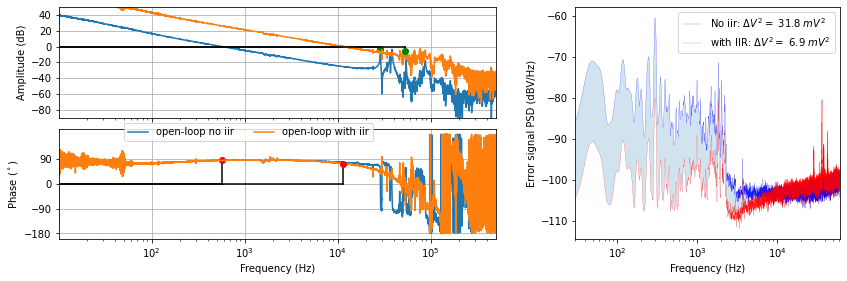

In [9]:
import h5py

fig = plt.figure(constrained_layout=True, figsize=(14, 4))
gs = fig.add_gridspec(2, 10)
ax_mag = fig.add_subplot(gs[0, :6])
ax_phase = fig.add_subplot(gs[1, :6], sharex=ax_mag)
ax_psd = fig.add_subplot(gs[:, 6:])



# load data without iir
kwds = {}
with h5py.File("../example5_loop_transfer_function/data/data.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]

open_loop_tf, plant_tf = get_open_loop_and_plant(**kwds)
gain_margin, phase_margin = get_gain_phase_margin(kwds["freqs_tf"], open_loop_tf=open_loop_tf)
plot_loop_tfs(is_plot_plant=False, is_plot_controller=False, is_plot_closed_loop=False, axes=(ax_mag, ax_phase), 
              phase_margin=phase_margin, gain_margin=gain_margin, **kwds, nyquist_min_freq=200)     


# load data with iir
kwds = {}
with h5py.File("./data/data.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]

open_loop_tf, plant_tf = get_open_loop_and_plant(**kwds)
gain_margin, phase_margin = get_gain_phase_margin(kwds["freqs_tf"], open_loop_tf=open_loop_tf)
plot_loop_tfs(is_plot_plant=False, is_plot_controller=False, is_plot_closed_loop=False, axes=(ax_mag, ax_phase), 
              phase_margin=phase_margin, gain_margin=gain_margin, **kwds, nyquist_min_freq=200)


ax_mag.set_xlim(min(kwds["freqs_tf"]), max(kwds["freqs_tf"]))
ax_mag.set_yticks([-80, -60, -40, -20, 0, 20, 40])
ax_mag.set_ylim(-90, 50)
ax_mag.legend(["open-loop no iir", "_nolegend_",
               "_nolegend_", "_nolegend_", 
               "open-loop with iir"], ncol=3, bbox_to_anchor=(0.73, -0.26), loc='lower right')


cutoff_freq = 50
analog_filter_tf = 1/(1 + 1j*kwds["freqs_tf"]/cutoff_freq)

external_loop_gain = -np.abs(open_loop_tf[10]/kwds["controller_tf"][10]) # avoid first point which is affected by filter loading


# Load psd noise spectra

kwds = {}
with h5py.File("./data/psd.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]
        
psd_freqs = kwds["freqs_psd"]
mask = psd_freqs>30
psd_freqs = psd_freqs[mask]
psd_no_iir = kwds["psd_pdh_no_iir"][mask]
psd_iir = kwds["psd_pdh"][mask]

psd_no_iir_db = 10*np.log10(psd_no_iir)
psd_iir_db = 10*np.log10(psd_iir)

var_no_iir = np.sum(psd_no_iir)*(psd_freqs[1] - psd_freqs[0])
var_iir = np.sum(psd_iir)*(psd_freqs[1] - psd_freqs[0])

ax_psd.semilogx(psd_freqs, psd_no_iir_db, '-', linewidth=0.2, alpha=0.9, color='blue', rasterized=True)
ax_psd.semilogx(psd_freqs, psd_iir_db, '-', markerfacecolor='none', linewidth=0.2, alpha=0.9, color='red', rasterized=True)
ax_psd.fill_between(psd_freqs, psd_no_iir_db, psd_iir_db, alpha=0.2, 
                                        where=(psd_no_iir > psd_iir), rasterized=True)
ax_psd.fill_between(psd_freqs, psd_no_iir_db, psd_iir_db, alpha=0.2, color='red', 
                                        where=(psd_iir_db > psd_no_iir_db), rasterized=True)
ax_psd.set_xlim(30, max(psd_freqs))
ax_psd.set_ylabel("Error signal PSD (dBV/Hz)")
ax_psd.set_xlabel("Frequency (Hz)")
ax_psd.legend([f"No iir: $\Delta V^2 = \,\,{var_no_iir*1e6:.1f}$ $mV^2$", f"with IIR: $\Delta V^2= \,\,{var_iir*1e6:.1f}$ $mV^2$"])

plt.subplots_adjust(hspace=0.1, wspace=12)


plt.savefig("./figure_example6.pdf", dpi=50)

### Scan P and I with/without iir

In [176]:
%%acquisition_cell noise_in_and_out_of_loop_scan_p_and_i_no_iir
import numpy as np
import tqdm
IS_IIR = False
if IS_IIR:
    STAGE = 3
    p_gains = np.logspace(0, 4, 10) # 20
    i_gains = np.logspace(0, np.log10(4e7), 11) # n21
else:
    STAGE = 2
    p_gains = np.logspace(-2, 2, 10) # Default p=100
    i_gains = np.logspace(-2, np.log10(1e7), 11) # Default i=5e4
    
N_RETRY = 3
from pyrpl.async_utils import sleep, wait



def output_of_stage(stage):
    stage = p.lockbox.sequence[stage]
    for out in [stage.outputs.piezo, stage.outputs.aux_output]:
        if out.lock_on:
            return p.lockbox.outputs[out.name]

def lock_safe(stage, p_gain, i_gain, n_retry=N_RETRY):
    out = output_of_stage(stage)
    p.lockbox.unlock()
    retry_cnt = 0
    while not p.lockbox.is_locked():
        set_safe_gains()
        lock_at_stage(stage)
        out.p = p_gain
        out.i = i_gain
        retry_cnt+=1
        if retry_cnt==n_retry:
            return False
        sleep(1)
    return True

def setup_scopes_for_variance_measurements():
    for scope in p.rp.scope, p_shg.rp.scope:
        scope.duration = 0.2
        scope.average = True
        scope.trace_average = 1
        scope.trigger_source='immediately'
        scope.rolling_mode = False
    p.rp.scope.input1 = p.lockbox.inputs.pdh
    p.rp.scope.input2 = p.lockbox.inputs.transmission
    p_shg.rp.scope.input1 = p_shg.lockbox1.inputs.pdh
    p_shg.rp.scope.input2 = p_shg.lockbox1.inputs.transmission

def lock_variance():
    """
    measures the in-loop and out-of-loop error signal variance
    """
    pdh_out = []
    pdh_in = []
    trans_out = []
    trans_in = []
    for i in range(10):
        res = p.rp.scope.single_async()
        pdh_out_t, trans_out_t = p_shg.rp.scope.single()
        pdh_in_t, trans_in_t = wait(res)
        pdh_out.append(pdh_out_t)
        pdh_in.append(pdh_in_t)
        trans_out.append(trans_out_t)
        trans_in.append(trans_in_t)
    pdh_out = np.array(pdh_out)
    pdh_in = np.array(pdh_in)
    trans_out = np.array(trans_out)
    trans_in = np.array(trans_in)
    return pdh_in.std(), trans_in.mean(), pdh_out.std(), trans_out.mean(), trans_in.std(), trans_out.std()


    
def set_safe_gains():
    p.lockbox.outputs.piezo.p = 1
    p.lockbox.outputs.piezo.i = 50
    p.lockbox.outputs.aux_output.p = 300
    p.lockbox.outputs.aux_output.i = 500
    
    
def boost_gain(stage):
    p.lockbox.inputs.pdh.quadrature_factor = 1000

loop = AcquisitionLoop()

setup_scopes_for_variance_measurements()

times = p.rp.scope.times
loop.append_data(times=times)

try:
    boost_gain(STAGE)
    for i_gain in tqdm.tqdm(loop(i_gains)):
        loop.append_data(i_gain=i_gain)
        for p_gain in loop(p_gains):
            loop.append_data(p_gain=p_gain)
            lock_safe(STAGE, p_gain, i_gain)
            retry_cnt = 0
            while(True):
                pdh_in_std, trans_in_mean, pdh_out_std, trans_out_mean, trans_in_std, trans_out_std = lock_variance()          
                if p.lockbox.is_locked():
                    break
                else:
                    retry_cnt+=1
                    if retry_cnt<=N_RETRY:
                        lock_safe(STAGE, p_gain, i_gain)
                    else:
                        pdh_in_std, trans_in_mean, pdh_out_std, trans_out_mean, trans_in_std, trans_out_std = [np.nan]*6
                        break
            loop.append_data(pdh_in_std=pdh_in_std, trans_in_mean=trans_in_mean, pdh_out_std=pdh_out_std,
                             trans_out_mean=trans_out_mean, trans_in_std=trans_in_std, trans_out_std=trans_out_std)
    save_acquisition(loop=loop, is_iir=IS_IIR)
finally:
    set_safe_gains()

11it [10:23, 56.72s/it]

saving to h5 G:/Mon Drive/exsqueez/measurements/squeezer\noise_in_and_out_of_loop_scan_p_and_i_no_iir\2022-09-22_08-08-09_noise_in_and_out_of_loop_scan_p_and_i_no_iir.h5


saving fig G:/Mon Drive/exsqueez/measurements/squeezer\noise_in_and_out_of_loop_scan_p_and_i_no_iir\2022-09-22_08-08-09_noise_in_and_out_of_loop_scan_p_and_i_no_iir_FIG1.pdf


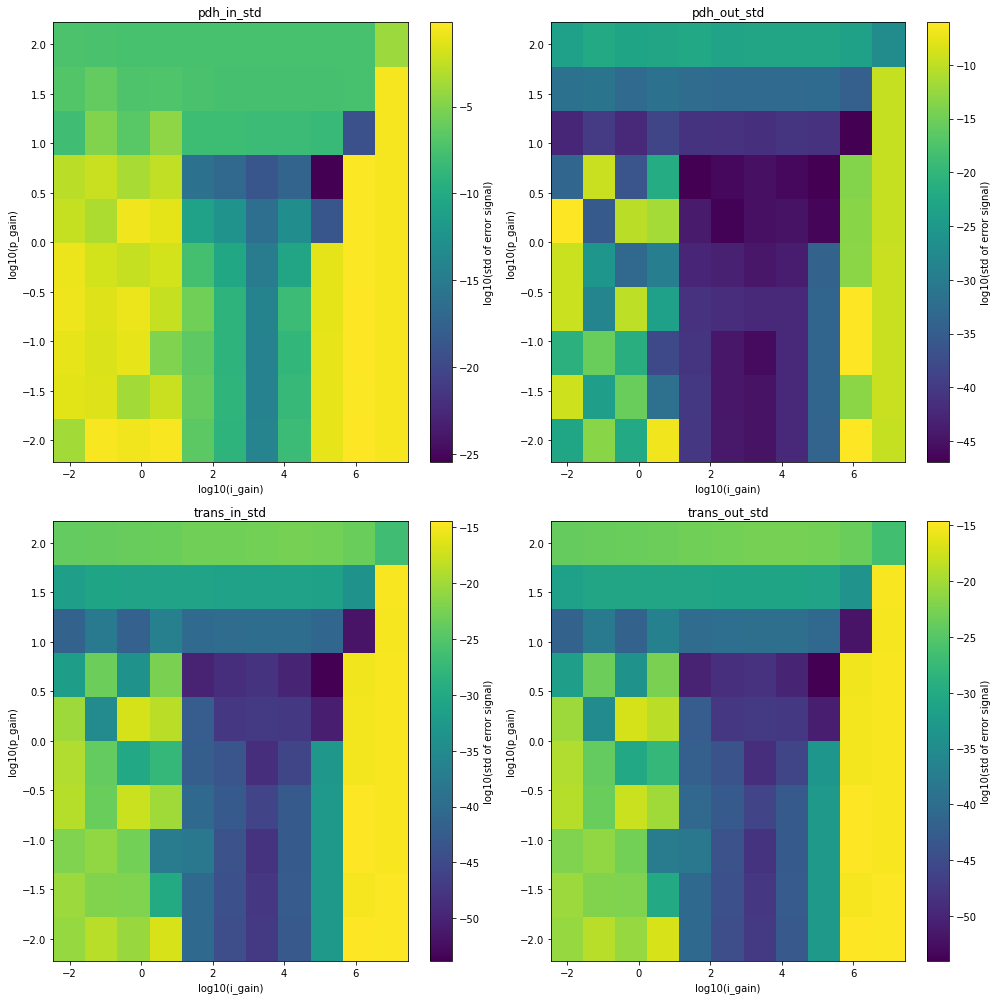

In [177]:
%%analysis_cell

data = load_acquisition()

fig = plt.figure(figsize=(14, 14))
for index, label in enumerate(('pdh_in_std', 'pdh_out_std', 'trans_in_std', 'trans_out_std')):
    plt.subplot(2, 2, index + 1)
    plt.pcolor(np.log10(data.loop.data["i_gain"].T[0]), 
               np.log10(data.loop.data["p_gain"][0]), 
               20*np.log10(data.loop.data[label].T))
    cbar = plt.colorbar()
    cbar.set_label("log10(std of error signal)")
    plt.xlabel("log10(i_gain)")
    plt.ylabel("log10(p_gain)")
    plt.title(label)
    plt.tight_layout()
data.save_fig(fig)

In [ ]:
%%acquisition_cell noise_in_and_out_of_loop_scan_p_and_i
from pyrpl.async_utils import wait, sleep
import tqdm


for sa in p.spectrumanalyzer, p_shg.spectrumanalyzer:
    sa.span = 6e4
    sa.trace_average = 5
p.spectrumanalyzer.input1_baseband = p.lockbox.inputs.pdh
p_shg.spectrumanalyzer.input1_baseband = p_shg.lockbox1.inputs.pdh

for scope in p.rp.scope, p_shg.rp.scope:
    scope.duration = 1
    scope.average = False
    scope.trace_average = 1
    scope.trigger_source='immediately'
    scope.rolling_mode = False
p.rp.scope.input1 = p.lockbox.inputs.pdh
p.rp.scope.input2 = p.lockbox.inputs.transmission
p_shg.rp.scope.input1 = p_shg.lockbox1.inputs.pdh
p_shg.rp.scope.input2 = p_shg.lockbox1.inputs.transmission

piezo = p.lockbox.outputs.piezo
DS = 10
old_p = p.lockbox.outputs.piezo.p
old_i = p.lockbox.outputs.piezo.i




p.lockbox.sequence[2].gain_factor = 1.

p_gains = np.logspace(-1, 2.5, 10) # Default p=100
i_gains = np.logspace(-1, np.log10(5e6), 11) # Default i=5e4

loop = AcquisitionLoop()
freqs = p.spectrumanalyzer.frequencies[::DS]
loop.append_data(freqs=freqs)
times = p.rp.scope.times
loop.append_data(times=times)
try:
    for i_gain in tqdm.tqdm(loop(i_gains)):
        loop.append_data(i_gain=i_gain)
        for p_gain in loop(p_gains):
            loop.append_data(p_gain=p_gain)
            lock_safe(p_gain, i_gain, N_RETRY)
            retry_cnt = 0
            while(True):
                res = p.spectrumanalyzer.single_async()
                psd_out, _, _, _ = p_shg.spectrumanalyzer.single()
                psd_in, _, _, _ = wait(res)
                psd_out = psd_out[::DS]
                psd_in = psd_in[::DS]

                pdh_in_loop, transmisson_in_loop = p.rp.scope.single()
                pdh_out_of_loop, transmisson_out_of_loop = p_shg.rp.scope.single()            
                if p.lockbox.is_locked():
                    break
                else:
                    retry_cnt+=1
                    if retry_cnt<=N_RETRY:
                        lock_safe(p_gain, i_gain, N_RETRY)
                    else:
                        psd_in = np.zeros(len(freqs))
                        psd_out = np.zeros(len(freqs))
                        pdh_in_loop, transmisson_in_loop = np.zeros((2, len(times)))
                        pdh_out_of_loop, transmisson_out_of_loop = np.zeros((2, len(times)))
                        break
            loop.append_data(psd_in=psd_in, psd_out=psd_out, pdh_in_loop=pdh_in_loop, transmisson_in_loop=transmisson_in_loop,
                            pdh_out_of_loop=pdh_out_of_loop, transmisson_out_of_loop=transmisson_out_of_loop)
    save_acquisition(loop=loop)
finally:
    p.lockbox.outputs.piezo.p = old_p
    p.lockbox.outputs.piezo.i = old_i

### Scan gains

In [17]:
%%acquisition_cell loop_tf_and_noise_inoutofloop_no_iir_scan_gain

START_FREQ = 30
STOP_FREQ = 5e5
GAIN_FACTOR = 1
Q_FACTOR_MIN = 20
RBW = 5
POINTS = 15000
AVG_PER_POINT = 5
STAGE_NUMBER = 2

AVG_PSD = 20
SPAN_PSD = 60e3

loop = AcquisitionLoop()
for gain_factor in loop(np.logspace(-2, 0, 5)):
    kwds = measure_loop_tf_and_noise(stage_number=STAGE_NUMBER, gain_factor=gain_factor, start_freq_tf=START_FREQ, stop_freq_tf=STOP_FREQ, 
                          points_tf=POINTS, q_factor_min=Q_FACTOR_MIN, rbw=RBW, avg_per_point=AVG_PER_POINT,
                          span_psd=SPAN_PSD, avg_psd=AVG_PSD)
    p_shg.spectrumanalyzer.setup(span=SPAN_PSD, input1_baseband=p_shg.lockbox1.inputs.pdh, trace_average=AVG_PSD)
    psd_out_of_loop, _, _, _ = p_shg.spectrumanalyzer.single()
    psd_out_of_loop_freqs = p_shg.spectrumanalyzer.frequencies
    loop.append_data(psd_out_of_loop=psd_out_of_loop, psd_out_of_loop_freqs=psd_out_of_loop_freqs)
    loop.append_data(closed_loop_tf=kwds["closed_loop_tf"], controller_tf=kwds["controller_tf"], psd_pdh=kwds["psd_pdh"], 
                     psd_output=kwds["psd_output"], gain_factor=kwds["gain_factor"], tf_bg=kwds["tf_bg"])
loop.append_data(freqs_tf=kwds['freqs_tf'], freqs_psd=kwds['freqs_psd'], slope_bw_per_v=kwds["slope_bw_per_v"], freqs_tf_bg=kwds['freqs_tf_bg'])

save_acquisition(loop_gain=loop)

C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\pyqtgraph\graphicsItems\PlotCurveItem.py:153: RuntimeWarning: All-NaN slice encountered
  b = (np.nanmin(d), np.nanmax(d))


saving to h5 G:/Mon Drive/exsqueez/measurements/squeezer\loop_tf_and_noise_no_iir_scan_gain\2022-09-17_14-43-14_loop_tf_and_noise_no_iir_scan_gain.h5


C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_6128\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_6128\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


saving fig G:\Mon Drive\exsqueez\measurements\squeezer\loop_tf_and_noise_no_iir_scan_gain\2022-09-17_14-43-14_loop_tf_and_noise_no_iir_scan_gain_FIG_gain_factor_0.010.pdf


C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_6128\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_6128\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


saving fig G:\Mon Drive\exsqueez\measurements\squeezer\loop_tf_and_noise_no_iir_scan_gain\2022-09-17_14-43-14_loop_tf_and_noise_no_iir_scan_gain_FIG_gain_factor_0.032.pdf


C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_6128\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_6128\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


saving fig G:\Mon Drive\exsqueez\measurements\squeezer\loop_tf_and_noise_no_iir_scan_gain\2022-09-17_14-43-14_loop_tf_and_noise_no_iir_scan_gain_FIG_gain_factor_0.100.pdf


C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_6128\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_6128\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


saving fig G:\Mon Drive\exsqueez\measurements\squeezer\loop_tf_and_noise_no_iir_scan_gain\2022-09-17_14-43-14_loop_tf_and_noise_no_iir_scan_gain_FIG_gain_factor_0.316.pdf


C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_6128\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_6128\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


saving fig G:\Mon Drive\exsqueez\measurements\squeezer\loop_tf_and_noise_no_iir_scan_gain\2022-09-17_14-43-14_loop_tf_and_noise_no_iir_scan_gain_FIG_gain_factor_1.000.pdf


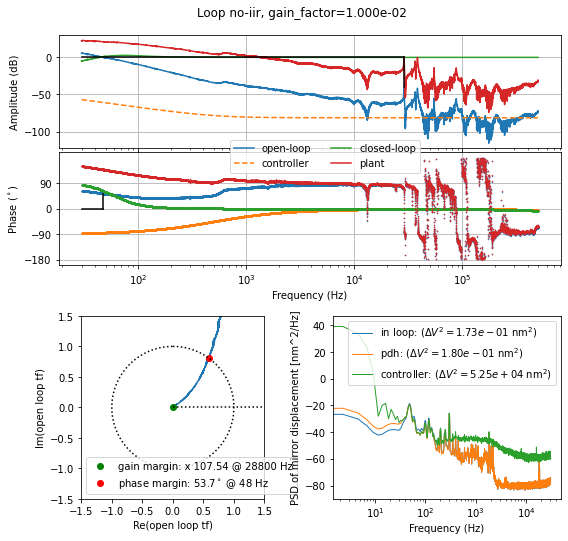

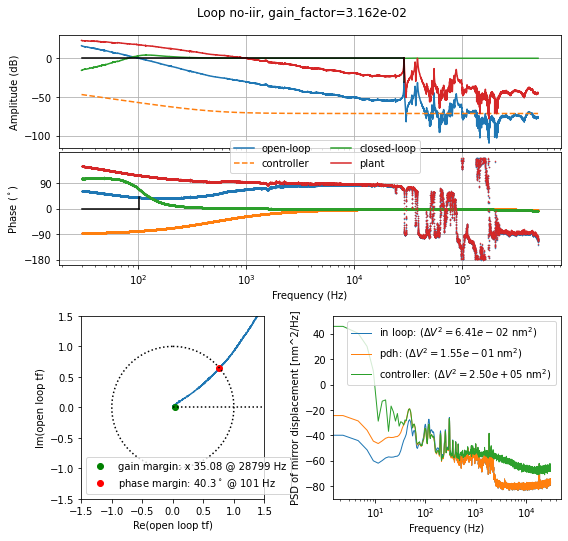

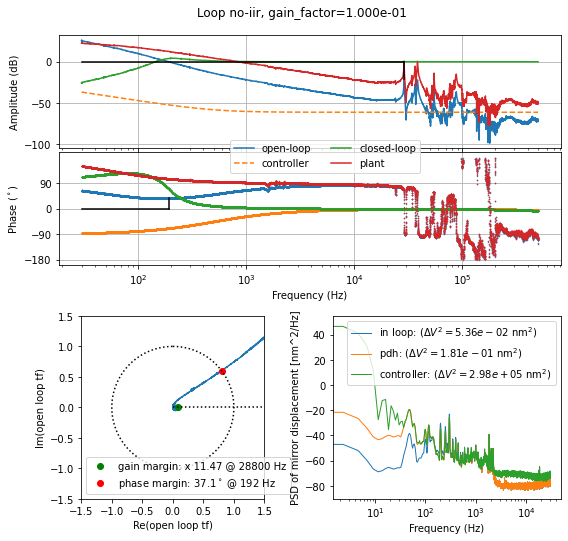

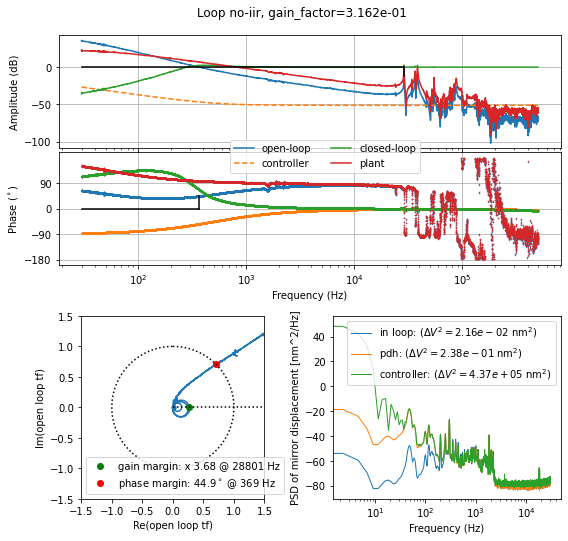

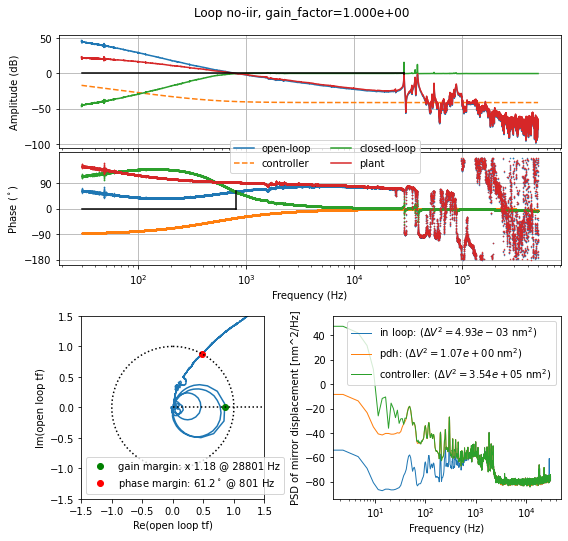

In [111]:
%%analysis_cell G:\Mon Drive\exsqueez\measurements\squeezer\loop_tf_and_noise_no_iir_scan_gain\2022-09-17_14-43-14_loop_tf_and_noise_no_iir_scan_gain.h5

data = load_acquisition()

for dat in data.loop_gain:
    analyze_loop_tf_and_noise(dat, nyquist_min_freq=30)
    data.save_fig(gcf(), name=f'gain_factor_{dat.gain_factor:.3f}')

### Scan p_gain and i_gain

In [70]:
%%acquisition_cell noise_in_and_out_of_loop_scan_p_and_i
from pyrpl.async_utils import wait, sleep
import tqdm


for sa in p.spectrumanalyzer, p_shg.spectrumanalyzer:
    sa.span = 6e4
    sa.trace_average = 5
p.spectrumanalyzer.input1_baseband = p.lockbox.inputs.pdh
p_shg.spectrumanalyzer.input1_baseband = p_shg.lockbox1.inputs.pdh

for scope in p.rp.scope, p_shg.rp.scope:
    scope.duration = 1
    scope.average = False
    scope.trace_average = 1
    scope.trigger_source='immediately'
    scope.rolling_mode = False
p.rp.scope.input1 = p.lockbox.inputs.pdh
p.rp.scope.input2 = p.lockbox.inputs.transmission
p_shg.rp.scope.input1 = p_shg.lockbox1.inputs.pdh
p_shg.rp.scope.input2 = p_shg.lockbox1.inputs.transmission

piezo = p.lockbox.outputs.piezo
DS = 10
old_p = p.lockbox.outputs.piezo.p
old_i = p.lockbox.outputs.piezo.i


N_RETRY = 5
def lock_safe(p_gain, i_gain, n_retry=N_RETRY):
    piezo.p = old_p
    piezo.i = old_i
    lock_at_stage(2)
    piezo.p = p_gain
    piezo.i = i_gain
    sleep(1)
    retry_cnt = 0
    while not p.lockbox.is_locked():
        piezo.p = old_p
        piezo.i = old_i
        lock_at_stage(2)
        piezo.p = p_gain
        piezo.i = i_gain
        retry_cnt+=1
        if retry_cnt==n_retry:
            return False
        sleep(1)
    return True

p.lockbox.sequence[2].gain_factor = 1.

p_gains = np.logspace(-1, 2.5, 10) # Default p=100
i_gains = np.logspace(-1, np.log10(5e6), 11) # Default i=5e4

loop = AcquisitionLoop()
freqs = p.spectrumanalyzer.frequencies[::DS]
loop.append_data(freqs=freqs)
times = p.rp.scope.times
loop.append_data(times=times)
try:
    for i_gain in tqdm.tqdm(loop(i_gains)):
        loop.append_data(i_gain=i_gain)
        for p_gain in loop(p_gains):
            loop.append_data(p_gain=p_gain)
            lock_safe(p_gain, i_gain, N_RETRY)
            retry_cnt = 0
            while(True):
                res = p.spectrumanalyzer.single_async()
                psd_out, _, _, _ = p_shg.spectrumanalyzer.single()
                psd_in, _, _, _ = wait(res)
                psd_out = psd_out[::DS]
                psd_in = psd_in[::DS]

                pdh_in_loop, transmisson_in_loop = p.rp.scope.single()
                pdh_out_of_loop, transmisson_out_of_loop = p_shg.rp.scope.single()            
                if p.lockbox.is_locked():
                    break
                else:
                    retry_cnt+=1
                    if retry_cnt<=N_RETRY:
                        lock_safe(p_gain, i_gain, N_RETRY)
                    else:
                        psd_in = np.zeros(len(freqs))
                        psd_out = np.zeros(len(freqs))
                        pdh_in_loop, transmisson_in_loop = np.zeros((2, len(times)))
                        pdh_out_of_loop, transmisson_out_of_loop = np.zeros((2, len(times)))
                        break
            loop.append_data(psd_in=psd_in, psd_out=psd_out, pdh_in_loop=pdh_in_loop, transmisson_in_loop=transmisson_in_loop,
                            pdh_out_of_loop=pdh_out_of_loop, transmisson_out_of_loop=transmisson_out_of_loop)
    save_acquisition(loop=loop)
finally:
    p.lockbox.outputs.piezo.p = old_p
    p.lockbox.outputs.piezo.i = old_i

0it [00:00, ?it/s]C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\pyqtgraph\graphicsItems\PlotCurveItem.py:153: RuntimeWarning: All-NaN slice encountered
  b = (np.nanmin(d), np.nanmax(d))
11it [12:41, 69.24s/it]

saving to h5 G:/Mon Drive/exsqueez/measurements/squeezer\noise_in_and_out_of_loop_scan_p_and_i\2022-09-20_09-31-03_noise_in_and_out_of_loop_scan_p_and_i.h5


saving fig G:/Mon Drive/exsqueez/measurements/squeezer\noise_in_and_out_of_loop_scan_p_and_i\2022-09-20_09-31-03_noise_in_and_out_of_loop_scan_p_and_i_FIG_in-loop.pdf
saving fig G:/Mon Drive/exsqueez/measurements/squeezer\noise_in_and_out_of_loop_scan_p_and_i\2022-09-20_09-31-03_noise_in_and_out_of_loop_scan_p_and_i_FIG_out-of-loop.pdf


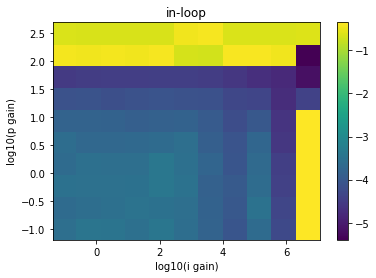

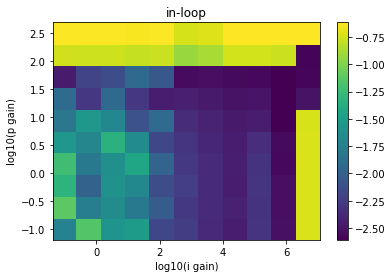

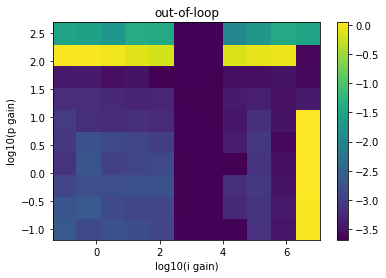

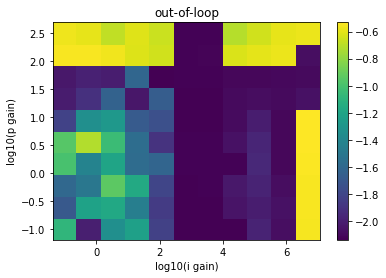

In [71]:
%%analysis_cell

plt.close('all')
data = load_acquisition()
FREQ_MIN = 15
IS_PLOT_SPECTRA = False
var_outs = np.zeros(data.loop.loop_shape)
var_ins = np.zeros(data.loop.loop_shape)
igains = []


for index_i, dat_i in enumerate(data.loop):
    for index_p, dat_p in enumerate(dat_i):
        name = f"p={dat_p.p_gain:.3e}, i={dat_p.i_gain:.3e}" 
        psd_out = dat_p.psd_out[dat_p.freqs>FREQ_MIN]
        psd_in = dat_p.psd_in[dat_p.freqs>FREQ_MIN]
        freqs = dat_p.freqs[dat_p.freqs>FREQ_MIN]
        var_out = np.sum(psd_out*(freqs[1] - freqs[0]))
        var_in = np.sum(psd_in[freqs>FREQ_MIN]*(freqs[1] - freqs[0]))
        var_outs[index_i, index_p] = var_out
        var_ins[index_i, index_p] = var_in
        if IS_PLOT_SPECTRA:
            plt.figure()
            plt.title(name)
            plt.semilogx(freqs, 10*np.log10(np.abs(psd_out)), label=f"out-of-loop $\Delta x^2$ = {var_out:.3e} nm$^2$")
            plt.semilogx(freqs, 10*np.log10(np.abs(psd_in)), label=f"in-loop  $\Delta x^2$ = {var_in:.3e} nm$^2$")
            plt.ylim(-110, -60)
            plt.legend()
            data.save_fig(gcf(), name=name)

        
for label, table, scope_data in (("in-loop", var_ins, data.loop.data["pdh_in_loop"]),
                                 ("out-of-loop", var_outs, data.loop.data["pdh_out_of_loop"])):
    fig = plt.figure()
    plt.pcolor(np.log10(data.loop.data['i_gain'].flatten()), np.log10(data.loop.data['p_gain'][0]), np.log10(table.T))
    plt.ylabel("log10(p gain)")
    plt.xlabel("log10(i gain)")
    plt.title(label)
    plt.colorbar()
    data.save_fig(fig, name=label)
    
    fig = plt.figure()
    plt.pcolor(np.log10(data.loop.data['i_gain'].flatten()), np.log10(data.loop.data['p_gain'][0]), 
                     np.log10(scope_data.std(axis=-1).T))
    plt.ylabel("log10(p gain)")
    plt.xlabel("log10(i gain)")
    plt.title(label)
    plt.colorbar()
   

In [85]:
data.loop.data["pdh_in_loop"].std(axis=-1).min()

0.002465808303018249

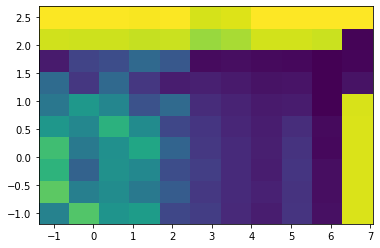

In [81]:
plt.figure()
plt.pcolor(np.log10(data.loop.data['i_gain'].flatten()), np.log10(data.loop.data['p_gain'][0]), np.log10(data.loop.data["pdh_in_loop"].std(axis=-1)).T)

In [19]:
%%analysis_cell

data = load_acquisition()

for dat in data.loop_gain:
    analyze_loop_tf_and_noise(dat, nyquist_min_freq=30)
    data.save_fig(plt.gcf())

C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12948\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12948\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


saving fig G:/Mon Drive/exsqueez/measurements/squeezer\loop_tf_and_noise_no_iir_scan_gain\2022-09-17_14-43-14_loop_tf_and_noise_no_iir_scan_gain_FIG1.pdf


C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12948\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12948\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


saving fig G:/Mon Drive/exsqueez/measurements/squeezer\loop_tf_and_noise_no_iir_scan_gain\2022-09-17_14-43-14_loop_tf_and_noise_no_iir_scan_gain_FIG2.pdf


C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12948\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12948\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


saving fig G:/Mon Drive/exsqueez/measurements/squeezer\loop_tf_and_noise_no_iir_scan_gain\2022-09-17_14-43-14_loop_tf_and_noise_no_iir_scan_gain_FIG3.pdf


C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12948\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12948\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


saving fig G:/Mon Drive/exsqueez/measurements/squeezer\loop_tf_and_noise_no_iir_scan_gain\2022-09-17_14-43-14_loop_tf_and_noise_no_iir_scan_gain_FIG4.pdf


C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12948\330512800.py:214: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(constrained_layout=True, figsize=(9, 8))
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12948\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_12948\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


saving fig G:/Mon Drive/exsqueez/measurements/squeezer\loop_tf_and_noise_no_iir_scan_gain\2022-09-17_14-43-14_loop_tf_and_noise_no_iir_scan_gain_FIG5.pdf


C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\pyqtgraph\graphicsItems\PlotCurveItem.py:153: RuntimeWarning: All-NaN slice encountered
  b = (np.nanmin(d), np.nanmax(d))


C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_4892\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_4892\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_4892\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_4892\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\OMQ SQZ 2.0\App

ValueError: data.save_analysis was never called

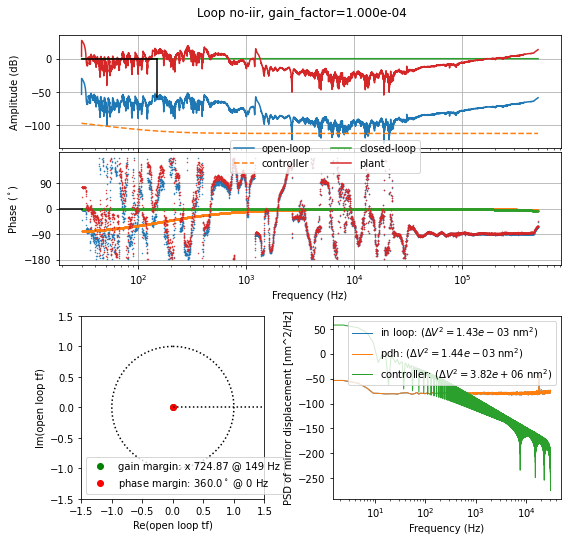

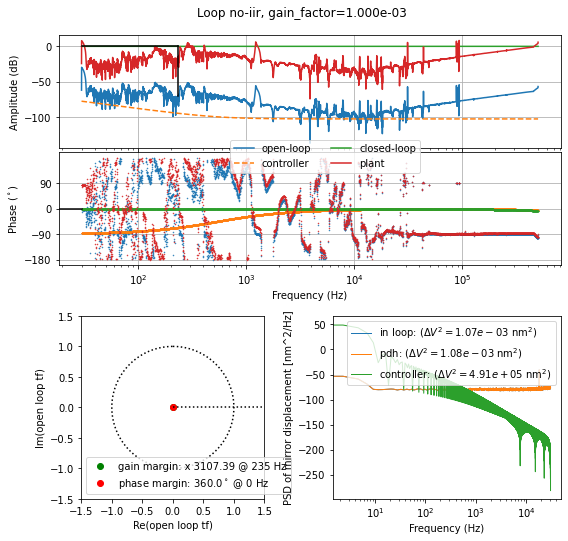

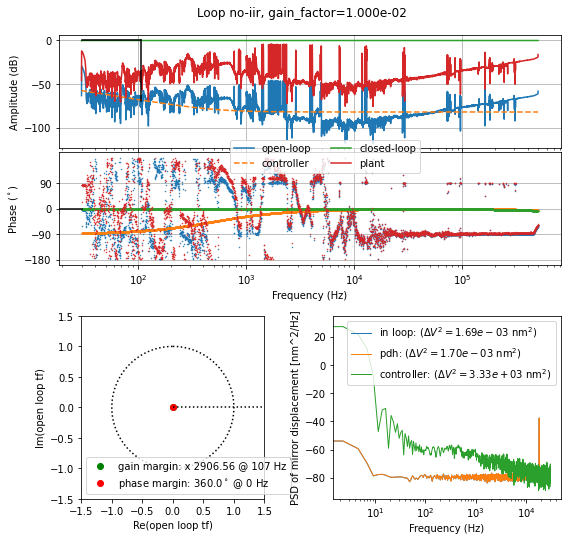

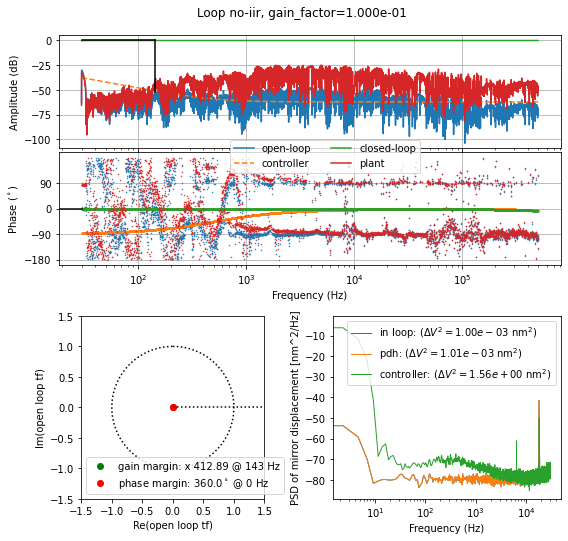

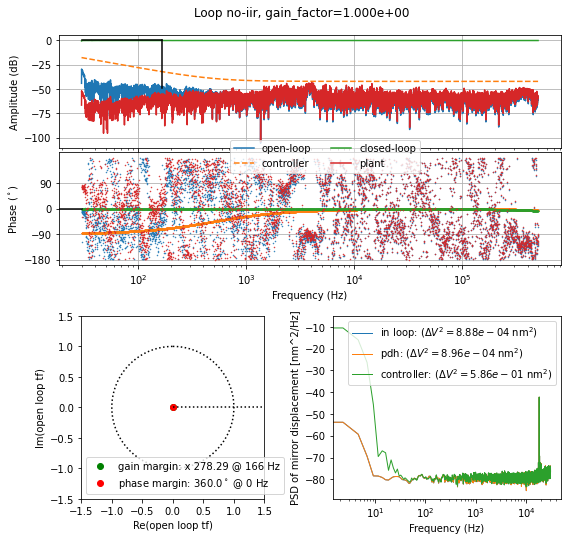

In [5]:
%%analysis_cell 

for closed_loop_tf, controller_tf, psd_pdh, \
    psd_output, gain_factor, tf_bg in zip(data.closed_loop_tf_all, data.controller_tf_all, 
                                          data.psd_pdh_all, data.psd_output_all, data.gain_factor_all, data.tf_bg_all):
    dat = AcquisitionData(closed_loop_tf=closed_loop_tf, controller_tf=controller_tf, psd_pdh=psd_pdh, 
                    psd_output=psd_output, gain_factor=gain_factor, tf_bg=tf_bg,
                    freqs_tf=data.freqs_tf, freqs_tf_bg=data.freqs_tf_bg, freqs_psd=data.freqs_psd, slope_bw_per_v=data.slope_bw_per_v)
    analyze_loop_tf_and_noise(dat)


In [391]:
%%analysis_cell G:\Mon Drive\exsqueez\measurements\squeezer\loop_tf_and_noise_no_iir\2022-09-14_20-32-12_loop_tf_and_noise_no_iir.h5

analyze_loop_tf_and_noise(data, nyquist_min_freq=100)

C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_10592\330512800.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_10592\330512800.py:247: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


ValueError: data.save_analysis was never called

In [269]:
%%acquisition_cell loop_tf_and_noise_no_iir

START_FREQ = 30
STOP_FREQ = 5e5
GAIN_FACTOR = 1
Q_FACTOR_MIN = 5
RBW = 100#5
POINTS = 5000
AVG_PER_POINT = 1




p.lockbox.sequence[2].gain_factor = GAIN_FACTOR


p.lockbox.inputs.pdh.mod_amp = 1
#out.additional_filter = 0
lock_without_iir()
START_AMP = min(10**(-55/10)*np.abs(current_output().transfer_function([10]))[0], 0.2)


freqs_tf, closed_loop_tf, controller_tf = \
    measure_closed_loop(start_freq=START_FREQ, stop_freq=STOP_FREQ, rbw=RBW, points=POINTS, amplitude_start=START_AMP, 
                        q_factor_min=Q_FACTOR_MIN, average_per_point=AVG_PER_POINT)

final_amplitude = p.networkanalyzer.amplitude_list[-1]
out = current_output()
#out.additional_filter = -1
#input("block laser")

#p.lockbox.unlock()
#current_output

p.lockbox.inputs.pdh.mod_amp = 0

freqs_tf_bg, tf_bg, _ = \
    measure_closed_loop(start_freq=START_FREQ, stop_freq=STOP_FREQ, rbw=RBW, points=100, q_factor_min=Q_FACTOR_MIN,
                        amplitude_start=final_amplitude, average_per_point=AVG_PER_POINT, is_auto_amplitude=False)

#out.additional_filter = 0
#input("open laser")
p.lockbox.inputs.pdh.mod_amp = 1
lock_without_iir()

freqs_psd, psd_pdh, psd_output = measure_spectrum(trace_average=20)
slope_bw_per_v = p.lockbox.inputs.pdh.expected_slope(0)

save_acquisition(freqs_tf=freqs_tf, closed_loop_tf=closed_loop_tf, controller_tf=controller_tf, 
                 freqs_psd=freqs_psd, psd_pdh=psd_pdh, psd_output=psd_output, slope_bw_per_v=slope_bw_per_v,
                 gain_factor=GAIN_FACTOR,
                 tf_bg=tf_bg, freqs_tf_bg=freqs_tf_bg)

saving to h5 2022-09-14_20-51-49_loop_tf_and_noise_no_iir
saving freqs_tf [3.00060492e+01 3.00642569e+01 3.01224645e+01 ... 4.98059148e+05
 4.99028625e+05 4.99999995e+05]
saving closed_loop_tf [-3.77964053e-04+0.00370125j -2.61067133e-03+0.00550851j
 -2.29210828e-03+0.0035287j  ...  9.27610716e-01-0.11634898j
  9.27313250e-01-0.11713938j  9.26166675e-01-0.1180922j ]
saving controller_tf [1.18693217-13.18593838j 1.18693217-13.16040899j 1.18693217-13.13497827j
 ... 1.183586   -0.0898578j  1.18357297 -0.09002929j
 1.18355988 -0.09020112j]
saving freqs_psd [0.00000000e+00 9.31322575e+00 1.86264515e+01 ... 1.22049823e+05
 1.22059137e+05 1.22068450e+05]
saving psd_pdh [1.61893407e-08 1.08756620e-08 3.12331014e-09 ... 2.94526397e-10
 2.79552293e-10 2.51473600e-10]
saving psd_output [1.43070336e+00 9.61801024e-01 2.73707180e-01 ... 4.23147001e-10
 3.79763835e-10 3.23383226e-10]
saving slope_bw_per_v 1.4006167103367284
saving gain_factor 1
saving tf_bg [0.96421549-1.46196712e-03j 0.99324356+2.6

In [377]:
%%analysis_cell

%pylab qt
NYQUIST_MIN_FREQ = 100

fig = plt.figure(constrained_layout=True, figsize=(9, 8))
gs = fig.add_gridspec(20, 2)
ax_mag = fig.add_subplot(gs[0:5, :])
ax_phase = fig.add_subplot(gs[5:10, :4], sharex=ax_mag)
ax_nyquist = fig.add_subplot(gs[12:, :1])
ax_spectra = fig.add_subplot(gs[12:, 1:])

#freqs_bg, background = np.load(r"G:/Mon Drive/exsqueez/measurements/squeezer/loop_tf_and_noise_no_iir/background.npy")

bg_tuple = data.freqs_tf, np.ones(len(data.freqs_tf))*np.mean(data.closed_loop_tf[-5:]) # np.load(SCAN_PATH + r"background.npy")

DS_FACTOR = 1
bg_downsampled = np.zeros(len(data.tf_bg)//DS_FACTOR, dtype=complex)
freqs_bg_downsampled = np.zeros(len(data.freqs_tf_bg)//DS_FACTOR)

for i in range(len(data.tf_bg)//DS_FACTOR):
    bg_downsampled[i] = data.tf_bg[DS_FACTOR*i:DS_FACTOR*(i+1)].mean()
    freqs_bg_downsampled[i] = data.freqs_tf_bg[DS_FACTOR*i:DS_FACTOR*(i + 1)].mean()
bg_tuple = (freqs_bg_downsampled, bg_downsampled)

open_loop_tf, plant_tf = get_open_loop_and_plant(data.freqs_tf, data.closed_loop_tf, data.controller_tf, background_correction=bg_tuple)
(gain_margin_z, gain_margin_freq), (phase_margin_z, phase_margin_freq) = plot_nyquist_diagram(data.freqs_tf, 
                                                                                              open_loop_tf, 
                                                                                              ax=ax_nyquist,
                                                                                              min_freq=NYQUIST_MIN_FREQ)
open_loop_tf, plant_tf = plot_loop_tfs(data.freqs_tf, 
                                       closed_loop_tf=data.closed_loop_tf, 
                                       controller_tf=data.controller_tf, 
                                       phase_margin=(np.angle(phase_margin_z), phase_margin_freq),
                                       gain_margin=(np.abs(gain_margin_z), gain_margin_freq),
                                       axes=[ax_mag, ax_phase], 
                                       background_correction=bg_tuple)
#bode_plot(data.freqs_tf, data.tf_bg, axes=(ax_mag, ax_phase))

FINESSE = 9
WAVELENGTH = 532e-9
BW_IN_M = WAVELENGTH/2/FINESSE/2

plot_loop_spectra(data.freqs_psd, data.psd_pdh, data.psd_output, 
                  slope_m_per_v=data.slope_bw_per_v*BW_IN_M,
                  freqs_closed_loop_tf=data.freqs_tf[5:],
                  closed_loop_tf=data.closed_loop_tf[5:],
                  controller_tf=data.controller_tf[5:],
                  ax=ax_spectra)
plt.suptitle(f"Loop no-iir, gain_factor={data.gain_factor:.3e}")
plt.tight_layout()
fig = gcf()

data.save_analysis(fig)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'power', 'display', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_10592\3732491857.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)
C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_10592\1168000807.py:52: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


In [343]:
print(np.sum(data.psd_pdh/np.abs(np.interp(data.freqs_psd, data.freqs_tf, data.closed_loop_tf))**2))
print(np.sum(data.psd_pdh))*np.diff(data.freqs_psd)[0]

0.08242097878512539
0.2654748496966327


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [341]:
plt.figure()
plt.plot(data.freqs_tf, np.abs(data.closed_loop_tf))
plt.plot(data.freqs_psd, data.psd_pdh)

In [254]:
p.networkanalyzer.amplitude_list[100]

0.9999923706054688

In [207]:
%%analysis_cell

%pylab qt
NYQUIST_MIN_FREQ = 10

fig = plt.figure(constrained_layout=True, figsize=(9, 8))
gs = fig.add_gridspec(20, 2)
ax_mag = fig.add_subplot(gs[0:5, :])
ax_phase = fig.add_subplot(gs[5:10, :4], sharex=ax_mag)
ax_nyquist = fig.add_subplot(gs[12:, :1])
ax_spectra = fig.add_subplot(gs[12:, 1:])

freqs_bg, background = np.load(r"G:/Mon Drive/exsqueez/measurements/squeezer/loop_tf_and_noise_no_iir/background.npy")

open_loop_tf, plant_tf = get_open_loop_and_plant(data.freqs_tf, data.closed_loop_tf, data.controller_tf, background_correction=(freqs_bg, background))
(gain_margin_z, gain_margin_freq), (phase_margin_z, phase_margin_freq) = plot_nyquist_diagram(data.freqs_tf, 
                                                                                              open_loop_tf, 
                                                                                              ax=ax_nyquist,
                                                                                              min_freq=NYQUIST_MIN_FREQ)
open_loop_tf, plant_tf = plot_loop_tfs(data.freqs_tf, 
                                       closed_loop_tf=data.closed_loop_tf, 
                                       controller_tf=data.controller_tf, 
                                       phase_margin=(np.angle(phase_margin_z), phase_margin_freq),
                                       gain_margin=(np.abs(gain_margin_z), gain_margin_freq),
                                       axes=[ax_mag, ax_phase], 
                                       background_correction=(freqs_bg, background))


FINESSE = 9
WAVELENGTH = 532e-9
BW_IN_M = WAVELENGTH/2/FINESSE/2

plot_loop_spectra(data.freqs_psd, data.psd_pdh, data.psd_output, 
                  slope_m_per_v=data.slope_bw_per_v*BW_IN_M,
                  freqs_closed_loop_tf=data.freqs_tf,
                  closed_loop_tf=data.closed_loop_tf,
                  controller_tf=data.controller_tf,
                  ax=ax_spectra)
plt.suptitle(f"Loop no-iir, gain_factor={data.gain_factor:.3e}")
plt.tight_layout()
fig = gcf()

data.save_analysis(fig)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


FileNotFoundError: [Errno 2] No such file or directory: 'G:/Mon Drive/exsqueez/measurements/squeezer/loop_tf_and_noise_no_iir/background.npy'

In [137]:
open_loop_tf, plant_tf = get_open_loop_and_plant(data.freqs_tf, data.closed_loop_tf, data.controller_tf, background_correction=(open_loop_tf, plant_tf))
open_loop_tf

array([4.06483953e+16+2.59670727e+16j, 1.10620649e+17+1.55781291e+17j,
       1.09013965e+17+1.56651988e+17j, 1.07835427e+17+1.57375692e+17j,
       1.05960485e+17+1.58857878e+17j, 1.04968581e+17+1.60300577e+17j,
       1.03857965e+17+1.59347920e+17j, 1.03484873e+17+1.58070823e+17j,
       1.00702646e+17+1.59846441e+17j, 9.92606648e+16+1.60482931e+17j,
       9.74036671e+16+1.60473336e+17j, 9.64995078e+16+1.61018264e+17j,
       9.57993182e+16+1.61461082e+17j, 9.47620480e+16+1.60881156e+17j,
       9.33846860e+16+1.61724968e+17j, 9.25617497e+16+1.61093021e+17j,
       9.09474759e+16+1.62171447e+17j, 8.99894225e+16+1.62314208e+17j,
       8.92393855e+16+1.63195003e+17j, 8.83665113e+16+1.63252743e+17j,
       8.78548727e+16+1.62985020e+17j, 8.52024953e+16+1.62359127e+17j,
       8.61150037e+16+1.64608369e+17j, 8.39409852e+16+1.65003393e+17j,
       8.49295707e+16+1.65437328e+17j, 8.43509136e+16+1.65894227e+17j,
       8.23196927e+16+1.65669089e+17j, 8.21118712e+16+1.66285319e+17j,
      

In [183]:
p.lockbox.inputs.pdh.iq.acbandwidth = 4e6

In [19]:
p.networkanalyzer.amplitude = 1.49e-3
p.networkanalyzer.auto_amplitude = False
p.lockbox.unlock()
zs_background = p.networkanalyzer.single()
freqs_background = p.networkanalyzer.frequencies
np.save(r"G:/Mon Drive/exsqueez/measurements/squeezer/loop_tf_and_noise_no_iir/background2.npy", (freqs_background, zs_background))

C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\pyqtgraph\graphicsItems\AxisItem.py:817: RuntimeWarning: overflow encountered in power
  estrings = ["%0.1g"%x for x in 10 ** np.array(values).astype(float) * np.array(scale)]


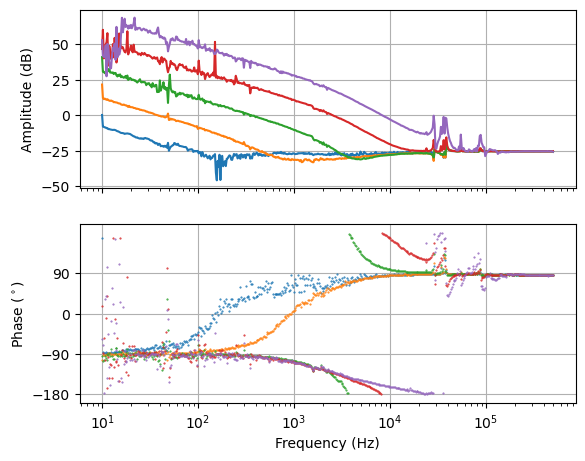

In [63]:
ax = axes2[0]
ax.get_figure()

In [155]:
%pylab qt
from glob import glob

axes = [None]*4
labels = ["closed_loops", "open_loops",  "open_loop_theory", "closed_loop_theory"]


SCAN_PATH = r"G:/Mon Drive/exsqueez/measurements/squeezer/loop_tf_and_noise_no_iir/scan_gain_factor_50kohms/"
filenames = glob(SCAN_PATH + '*.h5')
for filename in filenames:
    data = load_acquisition_data(filename)
    axes[0] = bode_plot(data.freqs_tf, data.closed_loop_tf, axes=axes[0], label=f"gain_factor: {data.gain_factor:.4f}")
    freqs_bg, background = data.freqs_tf, np.ones(len(data.freqs_tf))*np.mean(data.closed_loop_tf[-100:]) # np.load(SCAN_PATH + r"background.npy")
    
    #freqs_bg, background = np.load(SCAN_PATH + r"background.npy")
    
    
    freqs_bg = np.real(freqs_bg)
    open_loop_tf, plant_ft = get_open_loop_and_plant(data.freqs_tf, data.closed_loop_tf, data.controller_tf,
                                                     background_correction=(freqs_bg, background))
    axes[1] = bode_plot(data.freqs_tf, open_loop_tf, axes=axes[1], label=f"gain_factor: {data.gain_factor:.4f}")
    nu0 = 50
    open_loop_theory = -data.controller_tf*1/(1 + 1j*data.freqs_tf/nu0)*25
    axes[2] = bode_plot(data.freqs_tf, open_loop_theory, axes=axes[2],
                      label=f"gain_factor: {data.gain_factor:.4f}")
    axes[0] = bode_plot(data.freqs_tf, 1/(1 - open_loop_theory), axes=axes[0],
                      label=f"gain_factor: {data.gain_factor:.4f}")
    axes[3] = bode_plot(data.freqs_tf, 1/(1 - open_loop_theory), axes=axes[3],
                      label=f"gain_factor: {data.gain_factor:.4f}")
    
axes[0] = bode_plot(freqs_bg, background, axes=axes[0],
                  label=f"background")
for label, ax in zip(labels, axes):
    ax[0].legend()
    ax[0].get_figure().suptitle(label)
    ax[0].get_figure().savefig(SCAN_PATH + label + ".pdf")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
C:\Users\OMQ SQZ 2.0\Documents\GitHub\pyrpl\pyrpl\widgets\module_widgets\na_widget.py:230: RuntimeWarning: divide by zero encountered in log10
  xpos = np.log10(freq) if logscale else freq
C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:707: RuntimeWarning: invalid value encountered in double_scalars
  return QtCore.QRectF(xmn-px, ymn-py, (2*px)+xmx-xmn, (2*py)+ymx-ymn)
C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\pyqtgraph\functions.py:878: RuntimeWarning: invalid value encountered in multiply
  mapped = (m*coords).sum(axis=1)  ## apply scale/rotate


In [162]:
p.networkanalyzer.iq._na_averages/=3.5

In [36]:
print(current_output().pid.transfer_function([1e6]))
print(current_output().transfer_function_controller([1e6], p.lockbox.current_stage))

[0.00190126-0.00043912j]
[0.00190126-0.00043912j]


In [17]:
Pid.p.validate_and_normalize(p.rp.pid0, 0.0000001)

0.000244140625

In [14]:
bode_plot(freqs_tf, p.lockbox.outputs.piezo.transfer_function_controller(freqs_tf, p.lockbox.current_stage))

array([<AxesSubplot:ylabel='Amplitude (dB)'>,
       <AxesSubplot:xlabel='Frequency (Hz)', ylabel='Phase ($^\\circ$)'>],
      dtype=object)

In [29]:
np.abs(closed_loop_tf)

array([1.489182  , 0.62146007, 0.59939744, 0.60211025, 0.6280375 ,
       0.6358618 , 0.63700199, 0.64898445, 0.64405858, 0.66130278,
       0.69465626, 0.69544339, 0.70077199, 0.71718661, 0.70098217,
       0.73044747, 0.73363118, 0.74205833, 0.73172597, 0.72341924,
       0.72866685, 0.76762233, 0.75924217, 0.81015591, 0.78199721,
       0.77982809, 0.78737857, 0.81552174, 0.78927314, 0.78133491,
       0.78662398, 0.80077289, 0.79919268, 0.80088866, 0.81273673,
       0.83376338, 0.82218535, 0.83839878, 0.84032309, 0.85047784,
       0.84646205, 0.84880655, 0.85335046, 0.87665142, 0.85990268,
       0.87183163, 0.87557897, 0.88060363, 0.88256834, 0.88404033,
       0.88919887, 0.88118251, 0.87759914, 0.88825857, 0.89817863,
       0.89473707, 0.90571889, 0.91457267, 0.90507683, 0.9123548 ,
       0.92067866, 0.91971901, 0.91215967, 0.91262672, 0.90026503,
       0.92670001, 0.91914218, 0.91264024, 0.92167929, 0.91970611,
       0.90719179, 0.91102944, 0.95125625, 0.91218846, 0.92652

C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\ipykernel\eventloops.py:105: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  app.exec_()
C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\matplotlib\ticker.py:2377: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades
C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\matplotlib\ticker.py:2207: RuntimeWarning: invalid value encountered in double_scalars
  return abs(x - np.round(x)) < atol
C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\matplotlib\ticker.py:1077: RuntimeWarning: invalid value encountered in double_scalars
  coeff = round(b ** (fx - exponent))
Traceback (most recent call last):
  File "C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\matplotlib\backends\backend_qt.py", line 455, in _draw_idle
    self.draw()
  File "C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\matplotlib\backends\ba

## Compare noise spectral densities

0.15742219814449435
0.07617602880810409


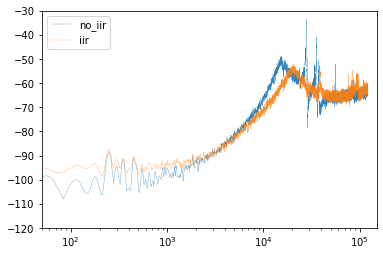

In [17]:
p.spectrumanalyzer.span = 2e5
p.spectrumanalyzer.baseband = True
p.spectrumanalyzer.input1_baseband = p.lockbox.inputs.pdh
p.spectrumanalyzer.input2_baseband = p.lockbox.inputs.transmission
p.spectrumanalyzer.trace_average = 20


def lock_without_iir():
    for stage_index in (0, 1, 2):
        is_locked = p.lockbox.sequence[stage_index].execute()
        ### Cavity should be locked at stage 2 (without IIR) 
    return is_locked

lock_without_iir()

psd_pdh_no_iir, psd_reflection_no_iir, cross_real_no_iir, cross_imag_no_iir = p.spectrumanalyzer.single()
psd_freqs = p.spectrumanalyzer.frequencies

p.lockbox.lock() # Lock with iir

psd_pdh_iir, psd_reflection_iir, cross_real_iir, cross_imag_iir = p.spectrumanalyzer.single()
psd_freqs = p.spectrumanalyzer.frequencies

plt.figure()
plt.semilogx(psd_freqs[::10], 10*np.log10(psd_pdh_no_iir[::10]), '-', linewidth=0.3, alpha=0.9, label='no_iir')
plt.semilogx(psd_freqs[::10], 10*np.log10(psd_pdh_iir[::10]), '-', linewidth=0.3, alpha=0.9, label='iir')
plt.xlim(50, 1.5e5)
plt.ylim(-120, -30)

plt.legend()

print(np.sum(psd_pdh_no_iir)*(psd_freqs[1] - psd_freqs[0]))
print(np.sum(psd_pdh_iir)*(psd_freqs[1] - psd_freqs[0]))

In [18]:
table = np.array((psd_freqs, psd_pdh_no_iir, psd_pdh_iir))
table = table[:, ::5] # Downsample spectra by a factor 5 to save space
np.save("./data/freqs_psdpdhnoiir_psdpdhiir2.npy", table)

## Plot the actual figure

C:\Users\OMQ SQZ 2.0\AppData\Local\Temp\ipykernel_8716\3130273904.py:30: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2, top=0.93)


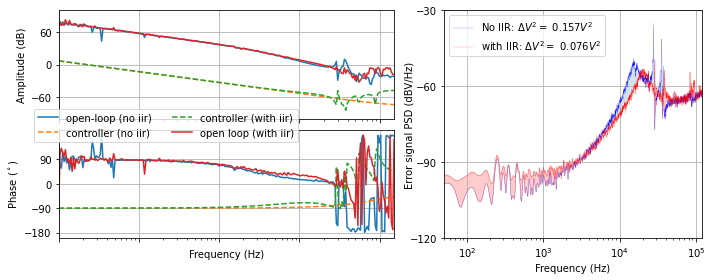

C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\pyqtgraph\graphicsItems\PlotCurveItem.py:153: RuntimeWarning: All-NaN slice encountered
  b = (np.nanmin(d), np.nanmax(d))


In [21]:
from pylab import *

freqs_no_iir, zs_no_iir, zpids_no_iir = np.load(f'./data/freqs_zclosed_zpids_close_tegam_no_iir.npy')
freqs_iir, zs_iir, zpids_iir = np.load(f'./data/freqs_zclosed_controller_close_tegam_iir2.npy')
freqs_iir = np.real(freqs_iir)
freqs_no_iir = np.real(freqs_no_iir)


def bode_plot(freqs, zs, axes=None, label=None, color=None, linestyle=None):
    """
    Plots the magnitude and phase of a complex series.
    """
    if axes is None:
        fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].semilogx(freqs, 20*np.log10(np.abs(zs)), linestyle=linestyle, color=color, label=label)
    axes[1].semilogx(freqs, 180/np.pi*np.angle(zs), ms=1, linestyle=linestyle, color=color, label=label)
    axes[0].set_xlim(1e1, 1.5e5)
    axes[0].set_xticklabels([])
    axes[1].set_ylim(-200, 200)
    axes[1].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel("Amplitude (dB)")
    axes[1].set_ylabel(r"Phase ($^\circ$)")

    axes[0].set_yticks([-120, -60, 0, 60, 120])
    axes[1].set_yticks([-180, -90, 0, 90, ])
    axes[0].tick_params(axis='x', which='minor', bottom=True)
    axes[1].tick_params(axis='x', which='minor', bottom=True)
    axes[0].grid(True)
    axes[1].grid(True)
    plt.subplots_adjust(hspace=0.2, top=0.93)
    return axes

DELAY_OUTPUT_TO_OUTPUT = 5*8e-9
zs_no_iir = zs_no_iir*np.exp(1j*2*np.pi*freqs_no_iir*DELAY_OUTPUT_TO_OUTPUT)
zs_iir = zs_iir*np.exp(1j*2*np.pi*freqs_iir*DELAY_OUTPUT_TO_OUTPUT)


open_loop_no_iir = 1 - 1/zs_no_iir
open_loop_iir = 1 - 1/zs_iir

fig = plt.figure(constrained_layout=True, figsize=(10, 4))
gs = fig.add_gridspec(2, 9)
ax_mag = fig.add_subplot(gs[0, :5])
ax_phase = fig.add_subplot(gs[1, :5], sharex=ax_mag)
ax_spectra = fig.add_subplot(gs[:, 5:])

## Plot transfer-functions
axes = bode_plot(freqs_no_iir, open_loop_no_iir, label='open-loop (no iir)', axes=(ax_mag, ax_phase))

bode_plot(freqs_no_iir, zpids_no_iir*1e-2, axes=axes, label='controller (no iir)', linestyle='--')
bode_plot(freqs_iir, zpids_iir*1e-2, axes=axes, label='controller (with iir)', linestyle='--')
bode_plot(freqs_iir, open_loop_iir, axes=axes, label='open loop (with iir)')
ax_mag.set_ylim(-100, 100)
# Add plot legend
axes[0].legend(ncol=2, bbox_to_anchor=(0.73, -0.26), loc='lower right')
axes[0].set_zorder(100)


##  Plot spectra
psd_freqs_loaded, psd_pdh_no_iir_loaded, psd_pdh_iir_loaded = \
np.load("./data/freqs_psdpdhnoiir_psdpdhiir2.npy")


mask = np.zeros(len(psd_freqs_loaded), dtype=bool)
for val in np.logspace(1, np.log10(1.5e5), 3001):
    mask[np.argmin(np.abs(psd_freqs_loaded - val))] = True
    
freqs_ds = psd_freqs_loaded[mask]
psd_iir = 10*np.log10(psd_pdh_iir_loaded[mask])
psd_no_iir = 10*np.log10(psd_pdh_no_iir_loaded[mask])

var_no_iir = np.sum(psd_pdh_no_iir_loaded)*(psd_freqs_loaded[1] - psd_freqs_loaded[0])
var_iir = np.sum(psd_pdh_iir_loaded[1:]*(psd_freqs_loaded[1] - psd_freqs_loaded[0]))


ax_spectra.semilogx(freqs_ds, psd_no_iir, '-', linewidth=0.2, alpha=0.9, color='blue')
ax_spectra.semilogx(freqs_ds, psd_iir, '-', markerfacecolor='none', linewidth=0.2, alpha=0.9, color='red')
ax_spectra.fill_between(freqs_ds, psd_no_iir, psd_iir, alpha=0.2, 
                                        where=(psd_no_iir > psd_iir))
ax_spectra.fill_between(freqs_ds, psd_no_iir, psd_iir, alpha=0.2, color='red', 
                                        where=(psd_iir > psd_no_iir))

ax_spectra.set_xlim(50, 1.2e5)
ax_spectra.set_ylim(-100, -30)
ax_spectra.grid(True)
ax_spectra.set_yticks([-30, -60, -90, -120])
ax_spectra.set_xlabel("Frequency (Hz)")
ax_spectra.set_ylabel("Error signal PSD (dBV/Hz)", labelpad=-5)
ax_spectra.legend([f"No IIR: $\Delta V^2 = \,\,{var_no_iir:.3f} V^2$", f"with IIR: $\Delta V^2= \,\,{var_iir:.3f} V^2$"])

plt.tight_layout()
subplots_adjust(hspace=.1)

fig.savefig("./figure_iir.pdf")

array([<AxesSubplot:ylabel='Amplitude (dB)'>,
       <AxesSubplot:xlabel='Frequency (Hz)', ylabel='Phase ($^\\circ$)'>],
      dtype=object)

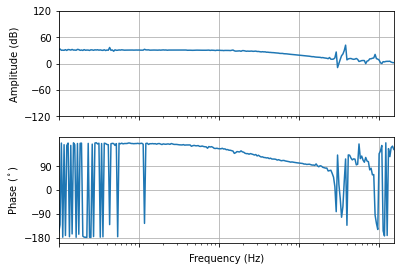

In [4]:
plant_iterative = open_loop_iir/zpids_iir
bode_plot(freqs_iir, plant_iterative)

In [47]:
from pyrpl import CurveDB

c = CurveDB("plant_iterative1")
c.data = freqs_iir, plant_iterative
c.save()

array([<AxesSubplot:ylabel='Amplitude (dB)'>,
       <AxesSubplot:xlabel='Frequency (Hz)', ylabel='Phase ($^\\circ$)'>],
      dtype=object)

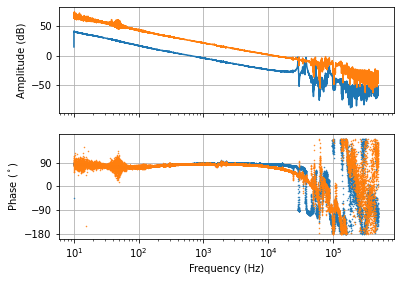

In [33]:
from acquisition_utils.data_structure import AnalysisData
data_no_iir = AnalysisData()
data_no_iir._load_from_h5("2022-09-23_09-47-15_loop_tf_and_noise.h5")
data_iir = AnalysisData()
data_iir._load_from_h5("2022-09-23_11-56-00_loop_tf_and_noise.h5")

open_loop_no_iir, plant_no_iir = get_open_loop_and_plant(data_no_iir.freqs_tf, data_no_iir.closed_loop_tf, data_no_iir.controller_tf, (data_no_iir.freqs_tf_bg, data_no_iir.tf_bg))
open_loop_iir, plant_iir = get_open_loop_and_plant(data_iir.freqs_tf, data_iir.closed_loop_tf, data_iir.controller_tf, (data_iir.freqs_tf_bg, data_iir.tf_bg))

axes = bode_plot(data_no_iir.freqs_tf, open_loop_no_iir)
bode_plot(data_iir.freqs_tf, open_loop_iir, axes=axes)

In [30]:

data_no_iir.fre


(array([3.75204733  -3.53071481j, 6.87518523+102.38344011j,
        3.54756501+112.27355225j, ..., 0.02671127  -0.2492174j ,
        0.02610544  -0.2499873j , 0.0268189   -0.25001843j]),
 array([  0.50125587+0.43610053j, -13.04936867+2.19745976j,
        -14.36120054+1.89751568j, ...,   0.05882187-0.31910108j,
          0.05812803-0.32015174j,   0.05906508-0.3201198j ]))